In [1]:
import numpy as np
import gzip
import os
import requests
import datetime
from numpy.typing import NDArray
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# define the network architecture and helper functions so we can load the weights into a model instance
def fetch_mnist_data() -> Tuple[Tuple[NDArray[np.uint8], NDArray[np.uint8]], Tuple[NDArray[np.uint8], NDArray[np.uint8]]]:
    """
    Downloads and loads the MNIST dataset into numpy arrays.
    The data is downloaded from Yann LeCun's website and saved locally.
    """

    # URLs for the MNIST dataset files
    urls = {
        'train_images': 'https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz',
        'train_labels': 'https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz',
        'test_images': 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz',
        'test_labels': 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz'
    }

    data_dir = 'mnist_data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Download and verify files
    for key, url in urls.items():
        filepath = os.path.join(data_dir, os.path.basename(url))
        if not os.path.exists(filepath):
            print(f"Downloading {url}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

    # Function to parse the IDX files
    def parse_idx_file(file_path: str, is_images: bool=True):
        with gzip.open(file_path, 'rb') as f:
            if is_images:
                # Skip the magic number (4 bytes) and number of images (4 bytes)
                # Read number of rows (4 bytes) and columns (4 bytes)
                f.read(8)
                rows = int.from_bytes(f.read(4), 'big')
                cols = int.from_bytes(f.read(4), 'big')
                buf = f.read()
                data = np.frombuffer(buf, dtype=np.uint8).reshape(-1, rows, cols)
            else:
                # Skip magic number (4 bytes) and number of items (4 bytes)
                f.read(8)
                buf = f.read()
                data = np.frombuffer(buf, dtype=np.uint8)
        return data

    X_train = parse_idx_file(os.path.join(data_dir, 'train-images-idx3-ubyte.gz'), is_images=True)
    y_train = parse_idx_file(os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'), is_images=False)
    X_test = parse_idx_file(os.path.join(data_dir, 't10k-images-idx3-ubyte.gz'), is_images=True)
    y_test = parse_idx_file(os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz'), is_images=False)

    return (X_train, y_train), (X_test, y_test)

def preprocess_data(X: NDArray[np.uint8], y: NDArray[np.uint8]) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Preprocesses the MNIST data for the MLP.
    - Flattens the 28x28 images into 784-element vectors.
    - Normalizes pixel values from [0, 255] to [0, 1].
    - One-hot encodes the labels.
    """
    # Flatten images
    X_flattened = X.reshape(X.shape[0], -1).astype('float32')

    # Normalize pixel values
    X_normalized = X_flattened / 255.0

    # One-hot encode labels
    y_one_hot = np.zeros((y.size, y.max() + 1))
    y_one_hot[np.arange(y.size), y] = 1

    return X_normalized.T, y_one_hot.T # Transpose for easier matrix math (features x examples)

In [3]:
# Model definitions and functions

def relu(Z: NDArray[np.float32]) -> NDArray[np.float32]:
    return np.maximum(0, Z)

def relu_derivative(Z: NDArray[np.float32]) -> NDArray[np.bool_]:
    """Derivative of the ReLU function."""
    return Z > 0

def softmax(Z: NDArray[np.float32]) -> NDArray[np.float32]:
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

class SimpleMLP:
    """A simple Multi-Layer Perceptron for classification."""
    W1: NDArray[np.float32]
    b1: NDArray[np.float32]
    W2: NDArray[np.float32]
    b2: NDArray[np.float32]

    def __init__(self, input_size, hidden_size, output_size):
        """
        Initializes the network's weights and biases.
        - W1, b1: Weights and bias for the hidden layer.
        - W2, b2: Weights and bias for the output layer.
        """
        # He initialization for weights is often better for ReLU
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((output_size, 1))

    def forward_pass(self, X: NDArray[np.float32]) -> Tuple[NDArray[np.float32], Dict[str, NDArray[np.float32]]]:
        """
        Performs the forward pass through the network.
        X -> [LINEAR -> RELU] -> [LINEAR -> SOFTMAX] -> A2
        Returns the final activation (A2) and a cache of intermediate values for backprop.
        """
        # Layer 1 (Hidden)
        Z1 = self.W1.dot(X) + self.b1
        A1 = relu(Z1)

        # Layer 2 (Output)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = softmax(Z2)

        # Cache values needed for the backward pass
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2, cache

    def backward_pass(self, X: NDArray[np.float32], Y: NDArray[np.float32], cache: Dict[str, NDArray[np.float32]]) -> Dict[str, NDArray[np.float32]]:
        """
        Performs the backward pass (backpropagation) to compute gradients.
        Y: The true labels (one-hot encoded).
        """
        m = X.shape[1] # Number of examples in the batch
        A1 = cache['A1']
        A2 = cache['A2']

        # --- Gradient calculation for the output layer (W2, b2) ---
        # The derivative of Cross-Entropy Loss with Softmax is simply (A2 - Y)
        dZ2 = A2 - Y
        dW2 = (1 / m) * dZ2.dot(A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        # --- Gradient calculation for the hidden layer (W1, b1) ---
        # Propagate the error back
        dZ1 = self.W2.T.dot(dZ2) * relu_derivative(cache['Z1'])
        dW1 = (1 / m) * dZ1.dot(X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return gradients

    def update_parameters(self, gradients, learning_rate):
        """
        Updates the network's parameters using gradient descent.
        """
        self.W1 -= learning_rate * gradients['dW1']
        self.b1 -= learning_rate * gradients['db1']
        self.W2 -= learning_rate * gradients['dW2']
        self.b2 -= learning_rate * gradients['db2']

class ConfigurableMLP:
    """A Multi-Layer Perceptron with a configurable number of layers."""

    def __init__(self, layer_dims: List[int]):
        """
        Initializes the network's parameters.
        
        Args:
            layer_dims: A list of integers specifying the number of neurons in each
                        layer, starting with the input layer.
                        Example: [784, 128, 64, 10]
        """
        self.params: Dict[str, NDArray[np.float32]] = {}
        self.num_layers = len(layer_dims)

        for layer in range(1, self.num_layers):
            # He initialization is good for ReLU layers
            self.params[f'W{layer}'] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(2. / layer_dims[layer-1])
            self.params[f'b{layer}'] = np.zeros((layer_dims[layer], 1))

    # def forward_pass(self, X: np.ndarray) -> Tuple[np.ndarray, List[Any]]:
    def forward_pass(self, X: NDArray[np.float32]) -> Tuple[NDArray[np.float32], Dict[str, NDArray[np.float32]]]:
        """
        Performs the forward pass through all layers of the network.
        """
        caches = []
        A = X
        
        # Loop through hidden layers (ReLU activation)
        for layer in range(1, self.num_layers - 1):
            A_prev = A
            W = self.params[f'W{layer}']
            b = self.params[f'b{layer}']
            
            Z = W.dot(A_prev) + b
            A = relu(Z)
            
            cache = {"A_prev": A_prev, "Z": Z}
            caches.append(cache)
            
        # Handle the output layer (Softmax activation)
        A_prev = A
        W_last = self.params[f'W{self.num_layers - 1}']
        b_last = self.params[f'b{self.num_layers - 1}']
        
        Z_last = W_last.dot(A_prev) + b_last
        A_last = softmax(Z_last)
        
        cache = {"A_prev": A_prev, "Z": Z_last}
        caches.append(cache)
        
        return A_last, caches

    def backward_pass(self, AL: NDArray[np.float32], Y: NDArray[np.float32], caches: List[Dict[str, NDArray[np.float32]]]) -> Dict[str, NDArray[np.float32]]:
        """
        Performs backpropagation to compute gradients for all layers.
        """
        grads: Dict[str, NDArray[np.float32]] = {}
        m = Y.shape[1]
        
        # --- Gradient for the output layer ---
        # The derivative of Cross-Entropy Loss with Softmax is simple
        dZ = AL - Y
        
        last_cache = caches[self.num_layers - 2]
        A_prev = last_cache['A_prev']
        
        grads[f'dW{self.num_layers - 1}'] = (1 / m) * dZ.dot(A_prev.T)
        grads[f'db{self.num_layers - 1}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.params[f'W{self.num_layers - 1}'].T.dot(dZ)
        
        # --- Loop backwards through the hidden layers ---
        for layer in reversed(range(1, self.num_layers - 1)):
            cache = caches[layer-1]
            Z = cache['A_prev']
            
            # Gradient for ReLU layer
            dZ = dA_prev * relu_derivative(cache['Z'])
            
            A_prev = cache['A_prev']
            grads[f'dW{layer}'] = (1 / m) * dZ.dot(A_prev.T)
            grads[f'db{layer}'] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = self.params[f'W{layer}'].T.dot(dZ)
            
        return grads

    def update_parameters(self, grads: Dict[str, NDArray[np.float32]], learning_rate: float):
        """
        Updates the network's parameters using gradient descent.
        """
        for layer in range(1, self.num_layers):
            self.params[f'W{layer}'] -= learning_rate * grads[f'dW{layer}']
            self.params[f'b{layer}'] -= learning_rate * grads[f'db{layer}']
    
    def get_input_gradient(self, AL: NDArray[np.float32], Y: NDArray[np.float32], caches: List[Dict[str, NDArray[np.float32]]]) -> NDArray[np.float32]:
        """
        Performs backpropagation to find the gradient of the loss with respect to the input layer (the image pixels).
        """
        L = self.num_layers - 1
        
        # The "error" at the output layer. We want to maximize the target neuron's output.
        dZ = AL - Y
        
        # Propagate the error backwards through all layers
        dA_prev = self.params[f'W{L}'].T.dot(dZ)
        
        for l in reversed(range(1, L)):
            cache = caches[l-1]
            # Backpropagate through the ReLU activation
            dZ = dA_prev * relu_derivative(cache['Z'])
            # Backpropagate through the linear layer
            dA_prev = self.params[f'W{l}'].T.dot(dZ)
            
        # The final dA_prev is the gradient with respect to the input image X
        return dA_prev

In [4]:
# Functions / Classes for plots
class TrainingHistory:
    def __init__(self, train_loss: List[float], train_accuracy: List[float], validation_loss: List[float], validation_accuracy: List[float]):
        self.train_loss = train_loss
        self.train_accuracy = train_accuracy
        self.validation_loss = validation_loss
        self.validation_accuracy = validation_accuracy

def plot_training_history(history: TrainingHistory, text: str = ""):
    """Plots the training and validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    if text:
        fig.suptitle(text, fontsize=14)
    
    # Plot Loss
    ax1.plot(history.train_loss, label='Training Loss', color='blue')
    ax1.plot(history.validation_loss, label='Validation Loss', color='orange')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot Accuracy
    ax2.plot(history.train_accuracy, label='Training Accuracy', color='blue')
    ax2.plot(history.validation_accuracy, label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_misclassified_images(
    X_test_orig: NDArray[np.float32],
    y_test_orig: NDArray[np.float32],
    y_pred: NDArray[np.float32],
    num_images: int = 25
):
    """
    Plots a grid of images that the model misclassified.
    """
    # Find the indices of all misclassified images
    misclassified_indices = np.where(y_pred != y_test_orig)[0]
    
    if len(misclassified_indices) == 0:
        print("Congratulations! No images were misclassified.")
        return
        
    print(f"Found {len(misclassified_indices)} misclassified images.")
    
    # Randomly select a subset of the misclassified images to display
    random_indices = np.random.choice(misclassified_indices, min(num_images, len(misclassified_indices)), replace=False)
    
    rows = int(np.ceil(np.sqrt(len(random_indices))))
    cols = int(np.ceil(len(random_indices) / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.7 * rows))
    axes = axes.flatten() # Flatten to make it easy to iterate
    
    for i, ax in enumerate(axes):
        if i < len(random_indices):
            idx = random_indices[i]
            ax.imshow(X_test_orig[idx], cmap='gray')
            ax.set_title(f"True: {y_test_orig[idx]}\nPred: {y_pred[idx]}")
            ax.axis('off')
        else:
            # Hide unused subplots
            ax.axis('off')
            
    plt.tight_layout()
    plt.suptitle("Misclassified Image Examples", fontsize=16, y=1.02)
    plt.show()

In [5]:
# Functions to train the model
def get_predictions(A2: NDArray[np.float32]) -> NDArray[np.int_]:
    """Gets the class predictions from the output activations."""
    return np.argmax(A2, axis=0)

def get_accuracy(predictions: NDArray[np.int_], Y: NDArray[np.float32]) -> float:
    """Calculates the accuracy of the predictions."""
    # Y is one-hot, so we get the true class index with argmax
    true_labels = np.argmax(Y, axis=0)
    return np.sum(predictions == true_labels) / Y.shape[1]

def calculate_loss(
    AL: NDArray[np.float32],
    Y: NDArray[np.float32],
    params: Dict[str, NDArray[np.float32]],
    regularization_strength: float
) -> float:
    """Calculates categorical cross-entropy loss with L2 regularization."""
    m = Y.shape[1]
    num_layers = len(params) // 2

    # Standard cross-entropy loss
    cross_entropy_cost = -np.sum(Y * np.log(AL + 1e-8)) / m

    # L2 regularization cost
    l2_regularization_cost = 0
    for l in range(1, num_layers + 1):
        l2_regularization_cost += np.sum(np.square(params[f'W{l}']))

    l2_regularization_cost = (regularization_strength / (2 * m)) * l2_regularization_cost

    # Total loss
    total_loss = cross_entropy_cost + l2_regularization_cost
    return total_loss

def train(
        X_train: NDArray[np.float32],
        Y_train: NDArray[np.float32],
        X_test: NDArray[np.float32],
        Y_test: NDArray[np.float32],
        epochs: int,
        learning_rate: float,
        batch_size: int,
        hidden_size: int
    ) -> Tuple[SimpleMLP, TrainingHistory]:
    """
    The main training loop for the neural network.
    """
    input_size = X_train.shape[0]
    output_size = Y_train.shape[0]
    num_samples = X_train.shape[1]

    training_history = TrainingHistory([], [], [], [])
    model = SimpleMLP(input_size, hidden_size, output_size)

    for i in range(epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[:, permutation]

        for j in range(0, num_samples, batch_size):
            # Get mini-batch
            end = j + batch_size
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[:, j:end]

            # 1. Forward pass
            A2, cache = model.forward_pass(X_batch)

            # 2. Backward pass
            gradients = model.backward_pass(X_batch, Y_batch, cache)

            # 3. Update parameters
            model.update_parameters(gradients, learning_rate)

        # Print progress after each epoch
        # Use the full training set for this calculation
        A2_full_train, _ = model.forward_pass(X_train)
        predictions_train = get_predictions(A2_full_train)
        accuracy_train = get_accuracy(predictions_train, Y_train)

        # Calculate loss (Categorical Cross-Entropy)
        loss_train = -np.sum(Y_train * np.log(A2_full_train + 1e-8)) / Y_train.shape[1] # add small epsilon for stability

        training_history.train_accuracy.append(accuracy_train)
        training_history.train_loss.append(loss_train)

        print(f"Epoch {i+1}/{epochs} - Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f}")

        # validation metrics
        A2_full_test, _ = model.forward_pass(X_test)
        predictions_test = get_predictions(A2_full_test)
        accuracy_test = get_accuracy(predictions_test, Y_test)

        # Calculate loss (Categorical Cross-Entropy)
        loss_test = -np.sum(Y_test * np.log(A2_full_test + 1e-8)) / Y_test.shape[1] # add small epsilon for stability
        training_history.validation_accuracy.append(accuracy_test)
        training_history.validation_loss.append(loss_test)

    return model, training_history

def train_configurable_mlp(
    X_train: NDArray[np.float32], 
    Y_train: NDArray[np.float32], 
    X_test: NDArray[np.float32], 
    Y_test: NDArray[np.float32], 
    layer_dimensions: List[int], 
    epochs: int, 
    learning_rate: float, 
    batch_size: int,
    regularization_strength: float = 0.0,
) -> Tuple[ConfigurableMLP, TrainingHistory]:
    """
    The main training loop for the configurable neural network.
    
    Args:
        X: Input data (features x number of examples).
        Y: True labels, one-hot encoded (classes x number of examples).
        layer_dims: A list defining the network architecture.
        epochs: Number of full passes through the training data.
        learning_rate: Step size for gradient descent.
        batch_size: Number of examples in each mini-batch.
        
    Returns:
        The trained model instance.
    """
    num_samples = X_train.shape[1]
    training_history = TrainingHistory([], [], [], [])

    # Initialize the model based on the provided architecture
    model = ConfigurableMLP(layer_dimensions)
    
    print(f"Starting training for model with architecture: layer_dimensions={layer_dimensions}, regularization_strength={regularization_strength}")
    
    for i in range(epochs):
        # Shuffle the data for each epoch to ensure random batches
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[:, permutation]

        for j in range(0, num_samples, batch_size):
            # Get mini-batch
            end = j + batch_size
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[:, j:end]

            # 1. Forward pass
            AL, caches = model.forward_pass(X_batch)
            
            # 2. Backward pass
            gradients = model.backward_pass(AL, Y_batch, caches)
            
            # 3. Update parameters
            model.update_parameters(gradients, learning_rate)
        
        # --- Logging after each epoch ---
        # Use the full training set for logging accuracy and loss
        AL_full_train, _ = model.forward_pass(X_train)
        predictions_train = get_predictions(AL_full_train)
        accuracy_train = get_accuracy(predictions_train, Y_train)
        
        # Calculate loss (Categorical Cross-Entropy)
        # loss_train = -np.sum(Y_train * np.log(AL_full_train + 1e-8)) / Y_train.shape[1]
        loss_train = calculate_loss(AL_full_train, Y_train, model.params, regularization_strength)

        training_history.train_accuracy.append(accuracy_train)
        training_history.train_loss.append(loss_train)
        
        print(f"Epoch {i+1}/{epochs} - Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f}")

        # validation metrics
        AL_full_test, _ = model.forward_pass(X_test)
        predictions_test = get_predictions(AL_full_test)
        accuracy_test = get_accuracy(predictions_test, Y_test)
        loss_test = calculate_loss(AL_full_test, Y_test, model.params, regularization_strength)
        training_history.validation_accuracy.append(accuracy_test)
        training_history.validation_loss.append(loss_test)
        
    return model, training_history


In [6]:
# Load and preprocess the test data
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fetch_mnist_data()
X_train, y_train = preprocess_data(X_train_orig, y_train_orig)
X_test, y_test = preprocess_data(X_test_orig, y_test_orig)
print("Test data loaded.")

Test data loaded.


In [7]:
# Training variables
EPOCHS = 40
LEARNING_RATE = 0.05
BATCH_SIZE = 128
HIDDEN_LAYER_SIZE = 512

# Train the model
print("\nStarting training...")
trained_model, training_history = train(
    X_train=X_train,
    Y_train=y_train,
    X_test=X_test,
    Y_test=y_test,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    hidden_size=HIDDEN_LAYER_SIZE
)
print("Training complete")

# Create the filename using the timestamp
# Note: It's often better to avoid spaces and colons in filenames
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
weights_file = f'./mlp_weights/mnist_mlp_weights_{timestamp}.npz'
print(f"Weights will be saved to: {weights_file}")

# After the training loop finishes
print("Saving model weights...")
np.savez(
    weights_file, 
    W1=trained_model.W1, 
    b1=trained_model.b1, 
    W2=trained_model.W2, 
    b2=trained_model.b2
)
print(f"Weights saved to {weights_file}")


Starting training...
Epoch 1/40 - Loss: 0.3318 - Accuracy: 0.9063
Epoch 2/40 - Loss: 0.2656 - Accuracy: 0.9263
Epoch 3/40 - Loss: 0.2304 - Accuracy: 0.9358
Epoch 4/40 - Loss: 0.2031 - Accuracy: 0.9437
Epoch 5/40 - Loss: 0.1825 - Accuracy: 0.9493
Epoch 6/40 - Loss: 0.1651 - Accuracy: 0.9542
Epoch 7/40 - Loss: 0.1545 - Accuracy: 0.9573
Epoch 8/40 - Loss: 0.1420 - Accuracy: 0.9602
Epoch 9/40 - Loss: 0.1312 - Accuracy: 0.9640
Epoch 10/40 - Loss: 0.1230 - Accuracy: 0.9667
Epoch 11/40 - Loss: 0.1158 - Accuracy: 0.9688
Epoch 12/40 - Loss: 0.1073 - Accuracy: 0.9712
Epoch 13/40 - Loss: 0.1027 - Accuracy: 0.9723
Epoch 14/40 - Loss: 0.0971 - Accuracy: 0.9744
Epoch 15/40 - Loss: 0.0909 - Accuracy: 0.9757
Epoch 16/40 - Loss: 0.0862 - Accuracy: 0.9769
Epoch 17/40 - Loss: 0.0822 - Accuracy: 0.9784
Epoch 18/40 - Loss: 0.0784 - Accuracy: 0.9795
Epoch 19/40 - Loss: 0.0751 - Accuracy: 0.9800
Epoch 20/40 - Loss: 0.0720 - Accuracy: 0.9809
Epoch 21/40 - Loss: 0.0688 - Accuracy: 0.9821
Epoch 22/40 - Loss: 0


Evaluating on the test set...
Test Accuracy: 0.9797
Found 203 misclassified images.


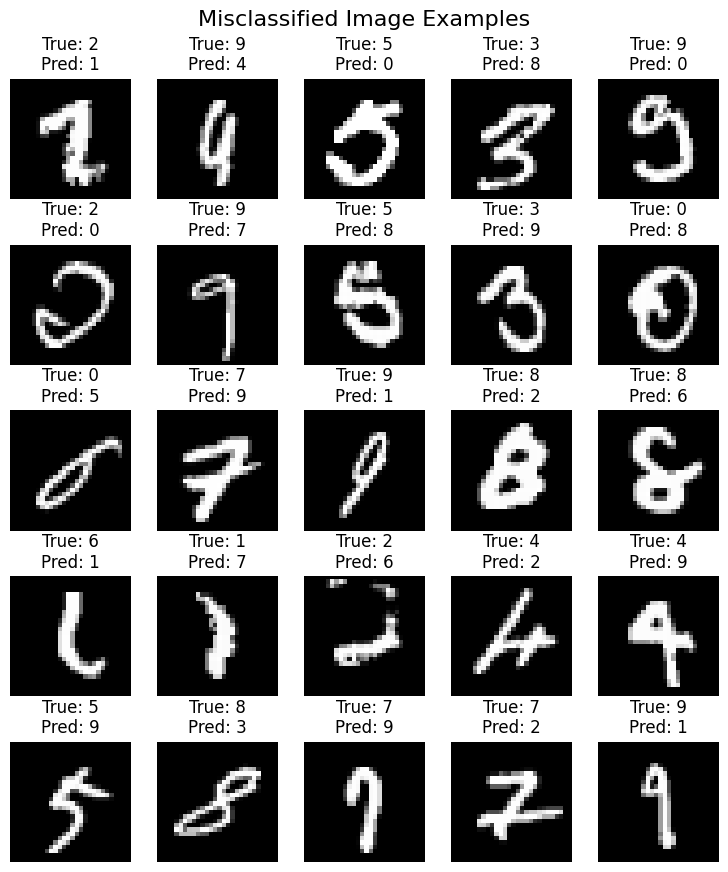

In [8]:
# Evaluate on the test set
print("\nEvaluating on the test set...")
A2_test, _ = trained_model.forward_pass(X_test)
predictions_test = get_predictions(A2_test)
test_accuracy = get_accuracy(predictions_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_misclassified_images(X_test_orig=X_test_orig, y_test_orig=y_test_orig, y_pred=predictions_test)

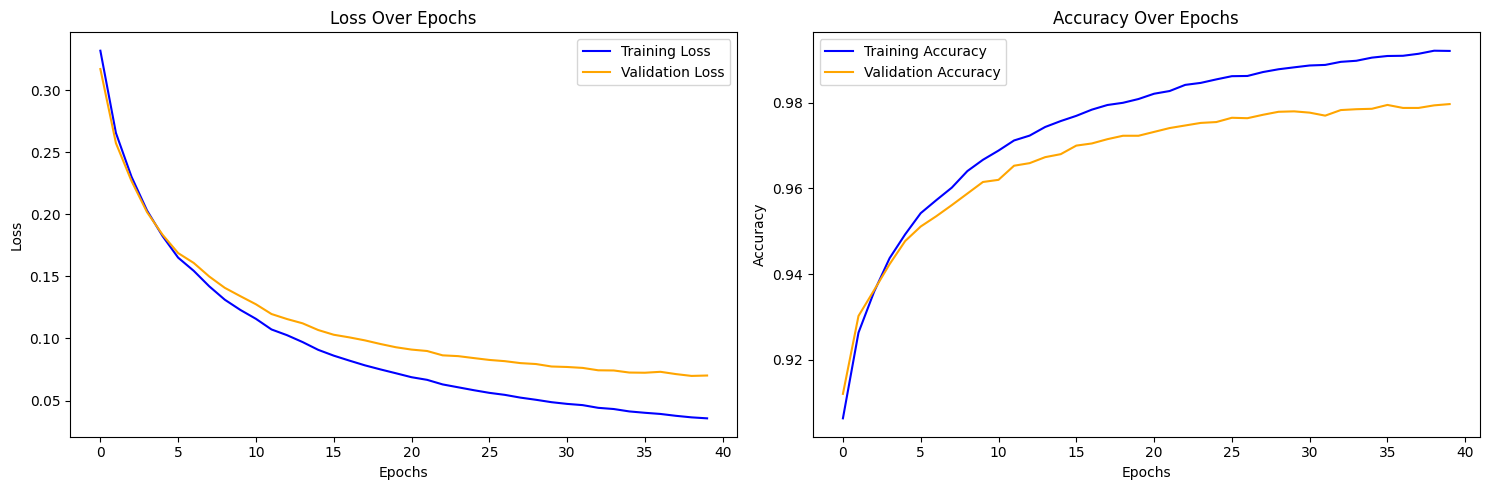

In [9]:
plot_training_history(training_history)

In [10]:
class MLPConfiguration:
    def __init__(self, layer_dimensions: List[int], epochs: int, learning_rate: float, batch_size: int, regularization_strength: float):
        self.layer_dimensions = layer_dimensions
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.regularization_strength = regularization_strength

    def __dict__(self):
        return {
            "layer_dimensions": self.layer_dimensions,
            "epochs": self.epochs,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "regularization_strength": self.regularization_strength,
        }

    def __str__(self):
        return str(self.__dict__())

mlp_configurations = [
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),

    MLPConfiguration(layer_dimensions=[784, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),

    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),

    MLPConfiguration(layer_dimensions=[784, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 512, 256, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),

    MLPConfiguration(layer_dimensions=[784, 512, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.0),
    MLPConfiguration(layer_dimensions=[784, 512, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.01),
    MLPConfiguration(layer_dimensions=[784, 512, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.1),
    MLPConfiguration(layer_dimensions=[784, 512, 512, 10], epochs=20, learning_rate=0.1, batch_size=256, regularization_strength=0.5),
]

In [11]:
configurable_mlp_results: List[Tuple[MLPConfiguration, ConfigurableMLP, TrainingHistory, float]] = []
for mlp_configuration in mlp_configurations:
    start = datetime.datetime.now()
    trained_configurable_model, configurable_model_training_history = train_configurable_mlp(
        X_train=X_train,
        Y_train=y_train,
        X_test=X_test,
        Y_test=y_test,
        layer_dimensions=mlp_configuration.layer_dimensions,
        epochs=mlp_configuration.epochs,
        learning_rate=mlp_configuration.learning_rate,
        batch_size=mlp_configuration.batch_size,
        regularization_strength=mlp_configuration.regularization_strength,
    )
    end = datetime.datetime.now()
    configurable_mlp_results.append((mlp_configuration, trained_configurable_model, configurable_model_training_history, (end - start).total_seconds()))

Starting training for model with architecture: layer_dimensions=[784, 10], regularization_strength=0.0
Epoch 1/20 - Loss: 0.4717 - Accuracy: 0.8770
Epoch 2/20 - Loss: 0.3997 - Accuracy: 0.8927
Epoch 3/20 - Loss: 0.3693 - Accuracy: 0.8992
Epoch 4/20 - Loss: 0.3522 - Accuracy: 0.9023
Epoch 5/20 - Loss: 0.3399 - Accuracy: 0.9065
Epoch 6/20 - Loss: 0.3305 - Accuracy: 0.9082
Epoch 7/20 - Loss: 0.3234 - Accuracy: 0.9102
Epoch 8/20 - Loss: 0.3176 - Accuracy: 0.9125
Epoch 9/20 - Loss: 0.3128 - Accuracy: 0.9127
Epoch 10/20 - Loss: 0.3091 - Accuracy: 0.9143
Epoch 11/20 - Loss: 0.3057 - Accuracy: 0.9149
Epoch 12/20 - Loss: 0.3021 - Accuracy: 0.9164
Epoch 13/20 - Loss: 0.2996 - Accuracy: 0.9165
Epoch 14/20 - Loss: 0.2973 - Accuracy: 0.9178
Epoch 15/20 - Loss: 0.2953 - Accuracy: 0.9183
Epoch 16/20 - Loss: 0.2931 - Accuracy: 0.9186
Epoch 17/20 - Loss: 0.2912 - Accuracy: 0.9190
Epoch 18/20 - Loss: 0.2893 - Accuracy: 0.9196
Epoch 19/20 - Loss: 0.2880 - Accuracy: 0.9202
Epoch 20/20 - Loss: 0.2868 - Acc


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 3.883856
Test Accuracy: 0.9207
Found 793 misclassified images.


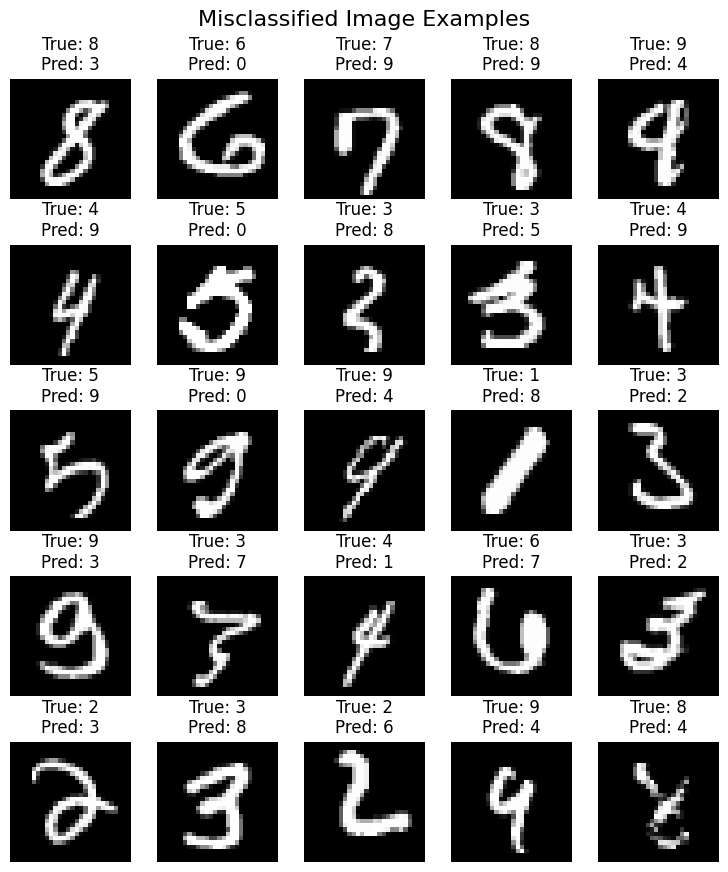


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 3.86081
Test Accuracy: 0.9211
Found 789 misclassified images.


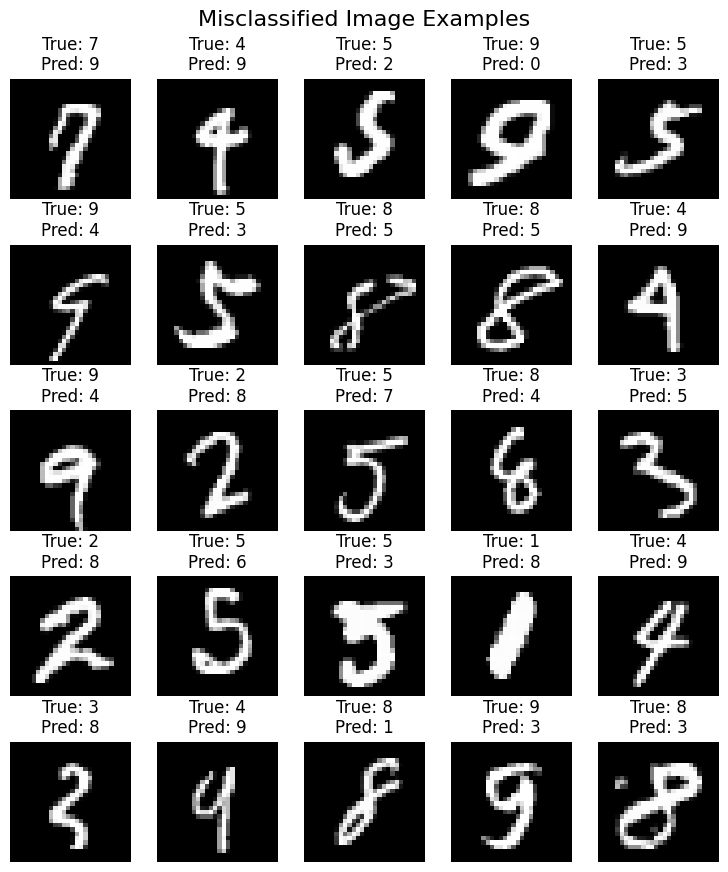


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 3.947474
Test Accuracy: 0.9203
Found 797 misclassified images.


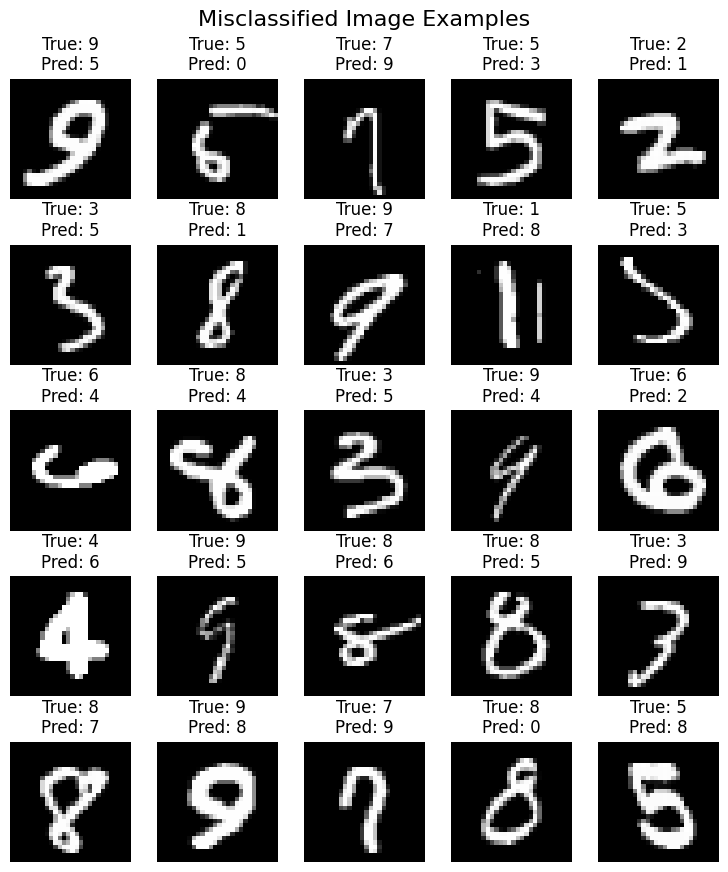


Evaluating on the test set for {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 3.785255
Test Accuracy: 0.9207
Found 793 misclassified images.


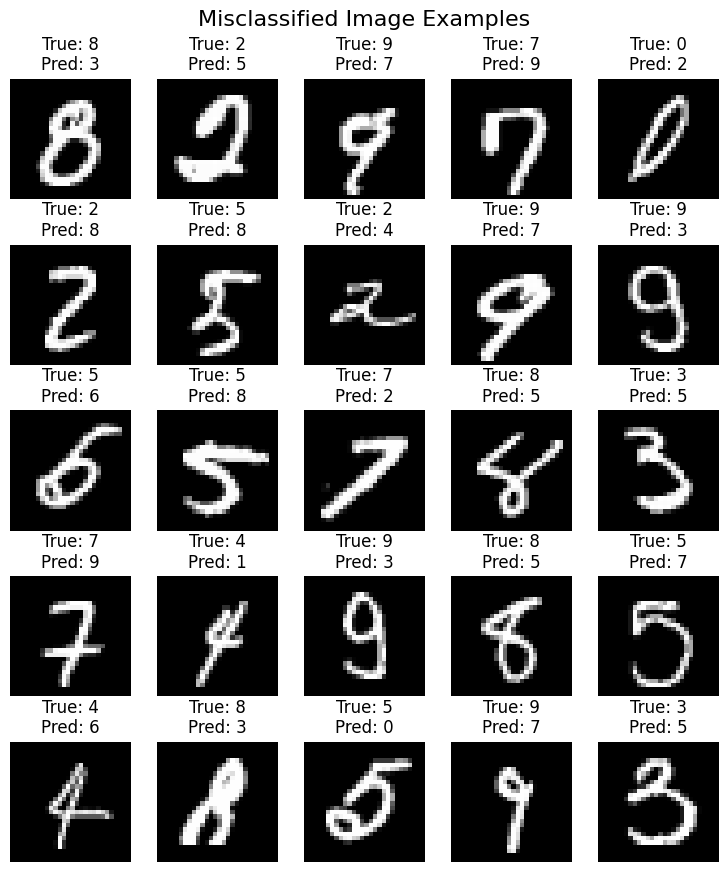


Evaluating on the test set for {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 11.162722
Test Accuracy: 0.9705
Found 295 misclassified images.


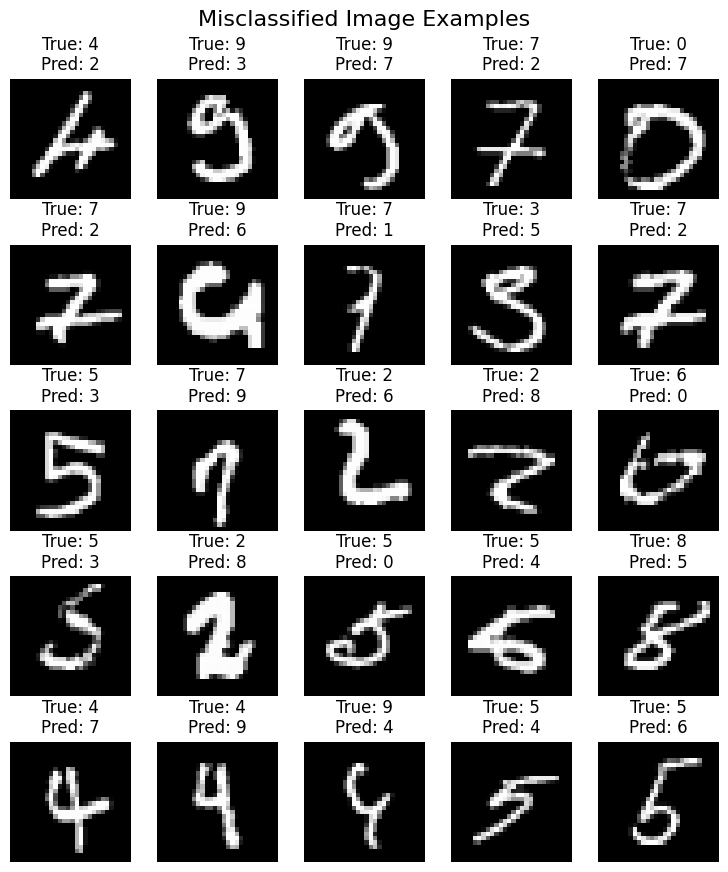


Evaluating on the test set for {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 10.00313
Test Accuracy: 0.9708
Found 292 misclassified images.


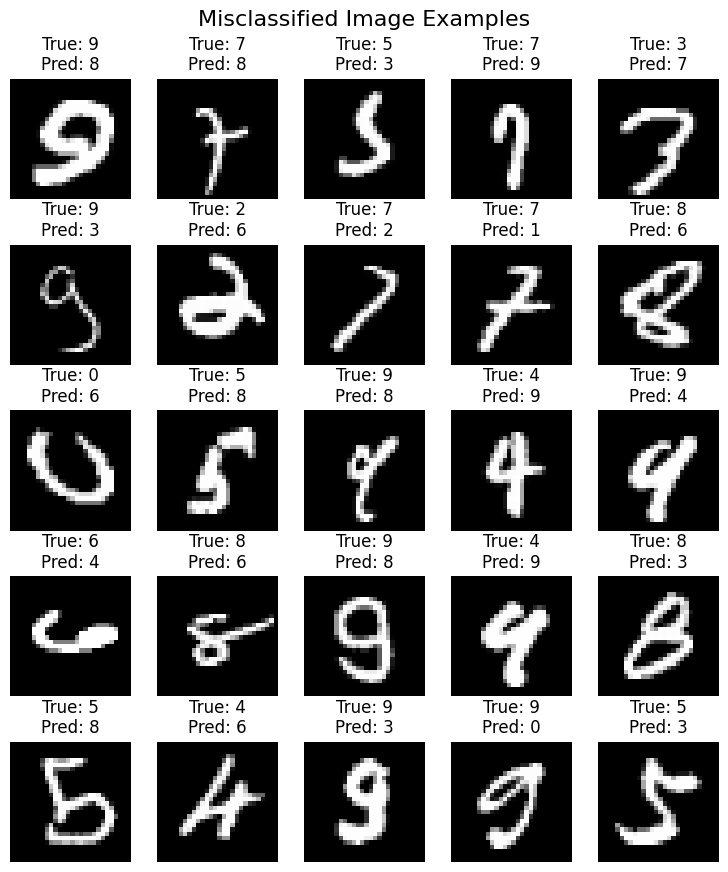


Evaluating on the test set for {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 10.229992
Test Accuracy: 0.9701
Found 299 misclassified images.


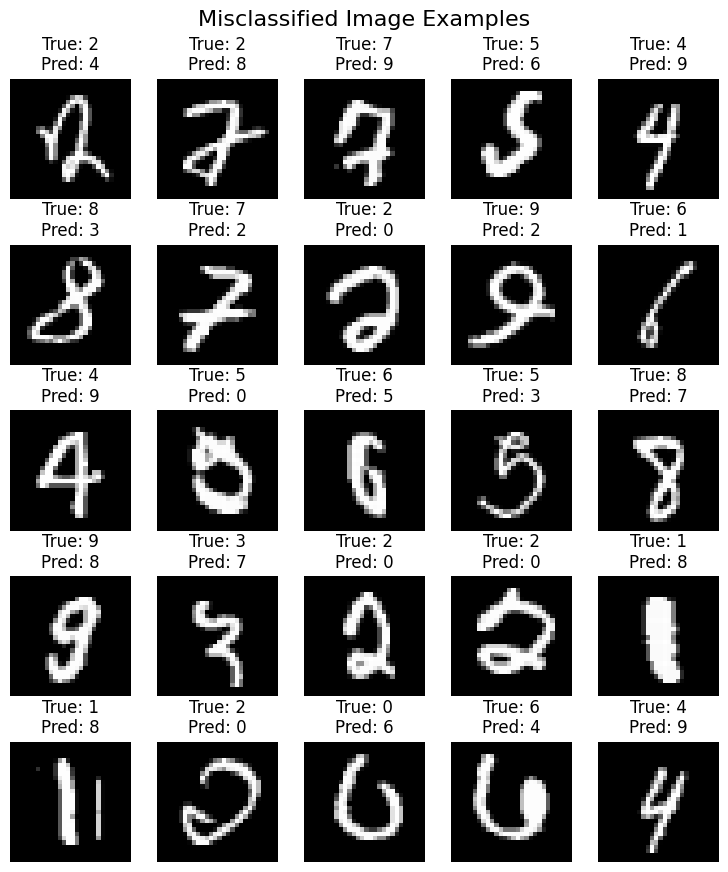


Evaluating on the test set for {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 10.364342
Test Accuracy: 0.9724
Found 276 misclassified images.


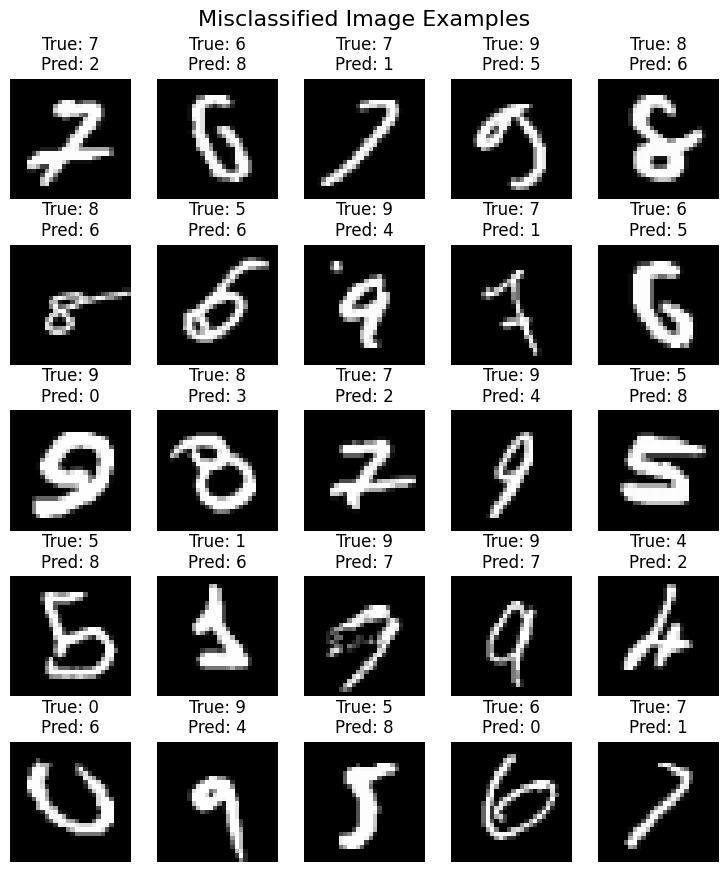


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 17.085377
Test Accuracy: 0.9710
Found 290 misclassified images.


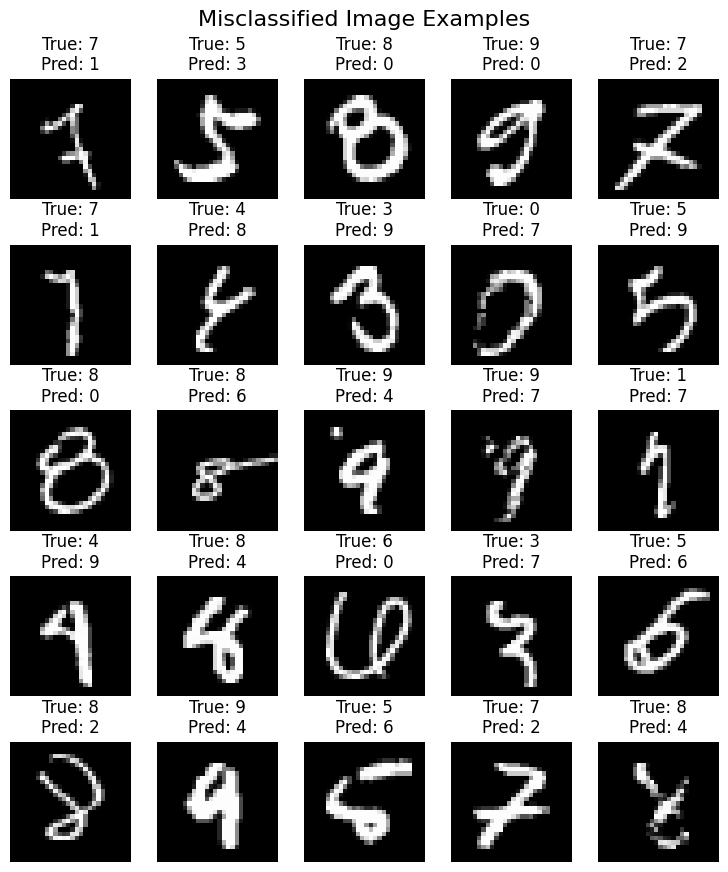


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 16.741793
Test Accuracy: 0.9726
Found 274 misclassified images.


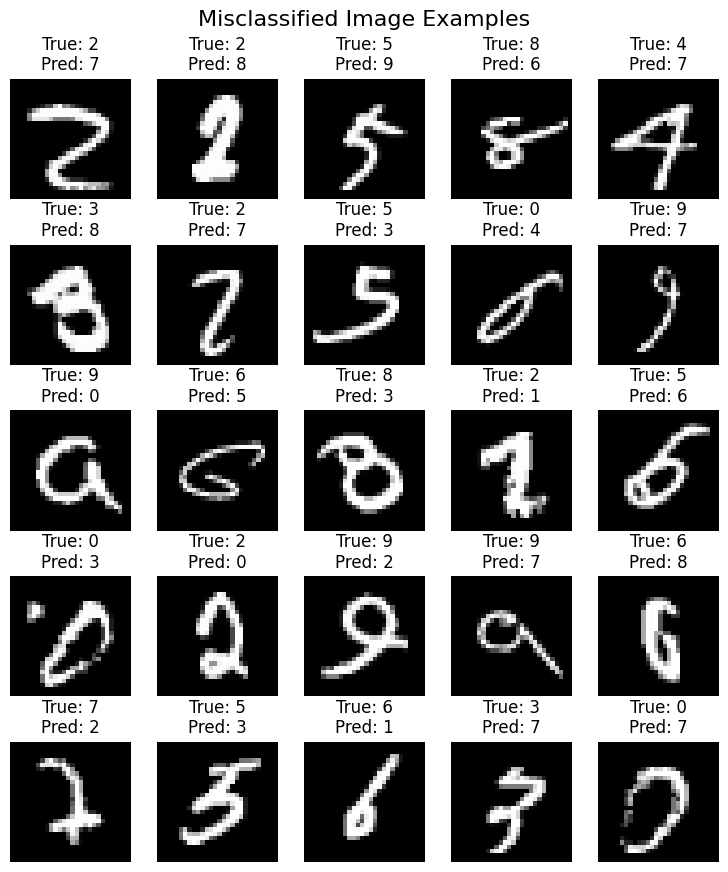


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 16.379712
Test Accuracy: 0.9746
Found 254 misclassified images.


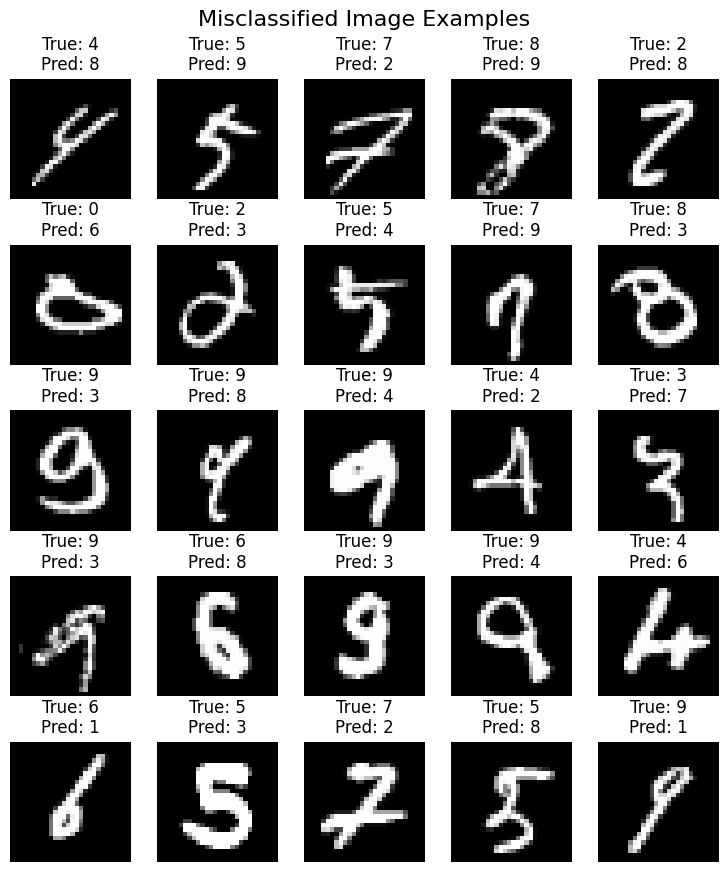


Evaluating on the test set for {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 17.013743
Test Accuracy: 0.9712
Found 288 misclassified images.


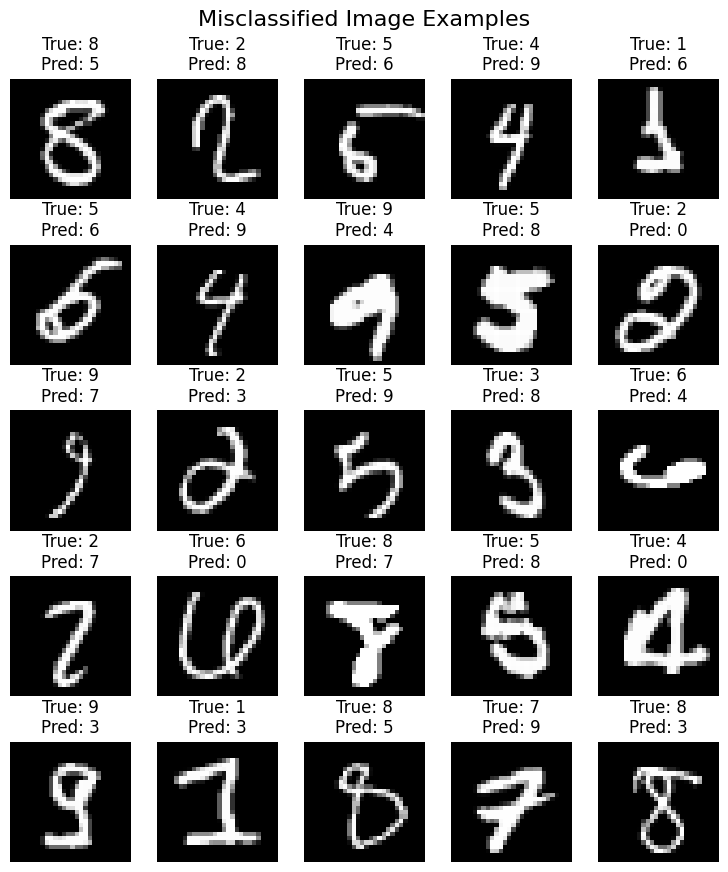


Evaluating on the test set for {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 22.058712
Test Accuracy: 0.9769
Found 231 misclassified images.


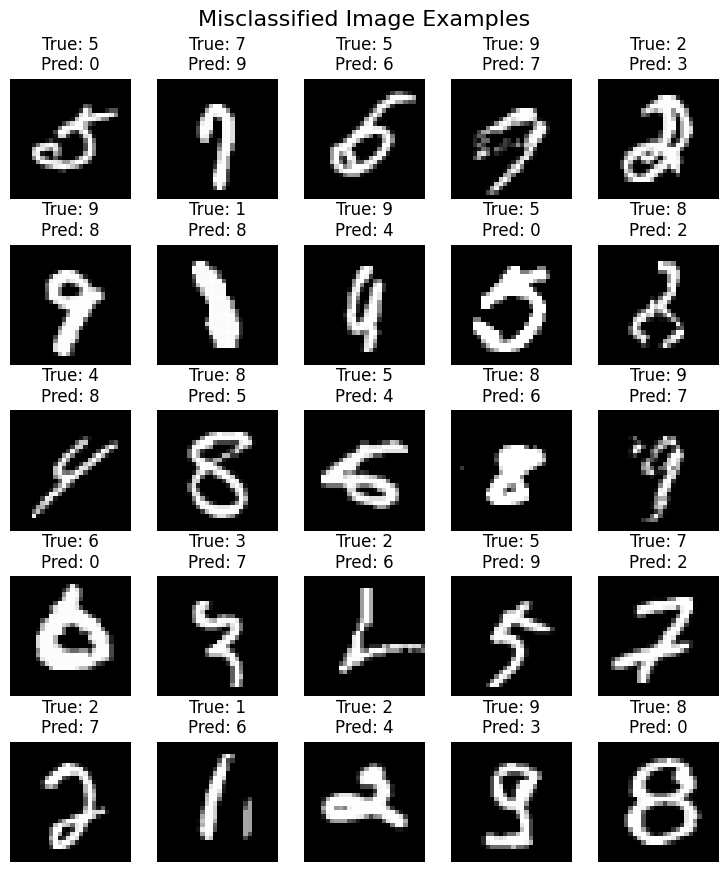


Evaluating on the test set for {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 22.407017
Test Accuracy: 0.9788
Found 212 misclassified images.


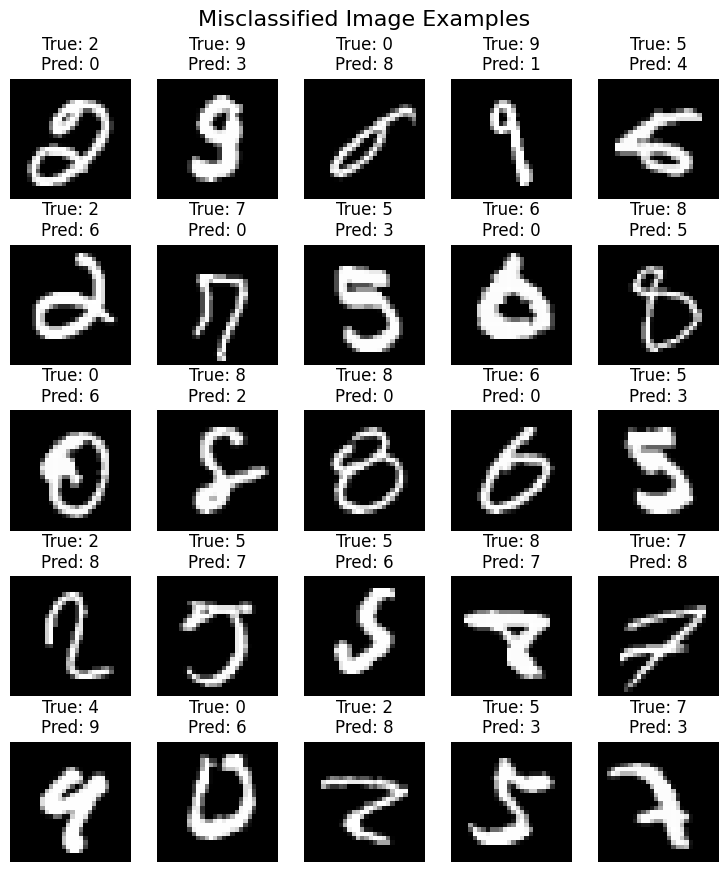


Evaluating on the test set for {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 22.103206
Test Accuracy: 0.9765
Found 235 misclassified images.


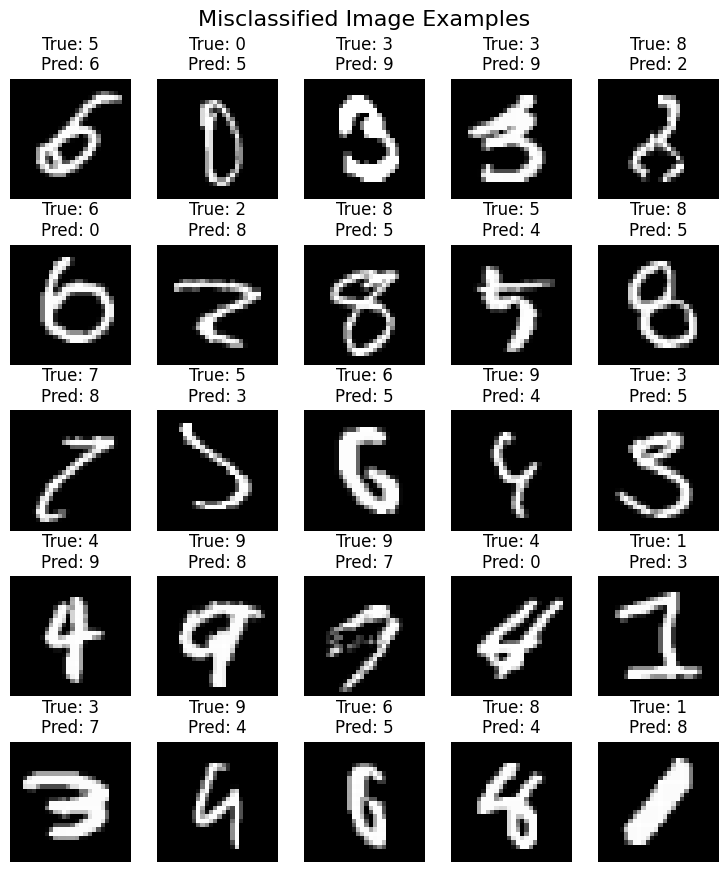


Evaluating on the test set for {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 21.753214
Test Accuracy: 0.9753
Found 247 misclassified images.


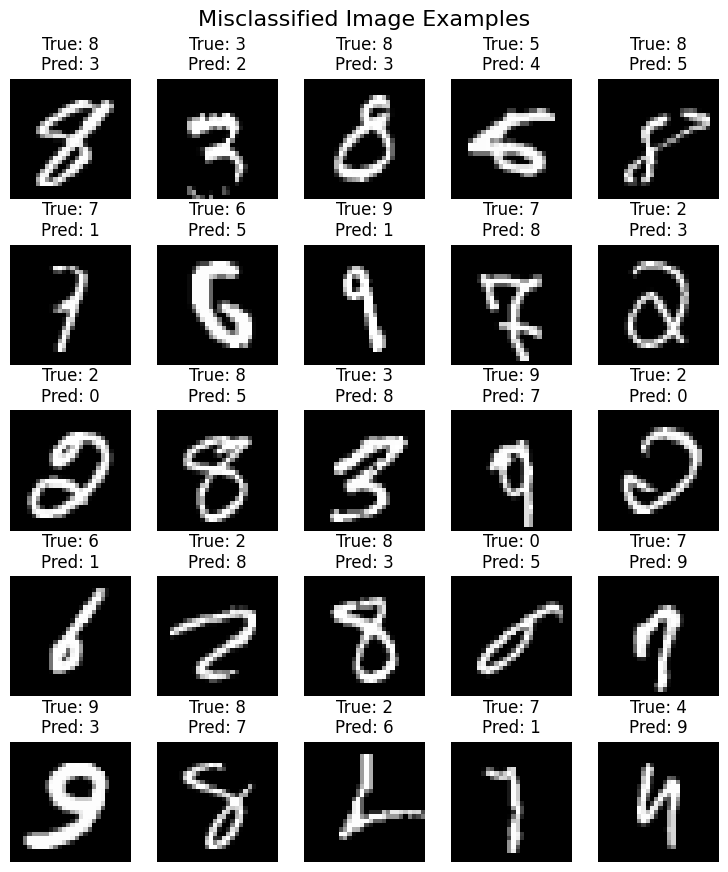


Evaluating on the test set for {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0} which took 27.38431
Test Accuracy: 0.9775
Found 225 misclassified images.


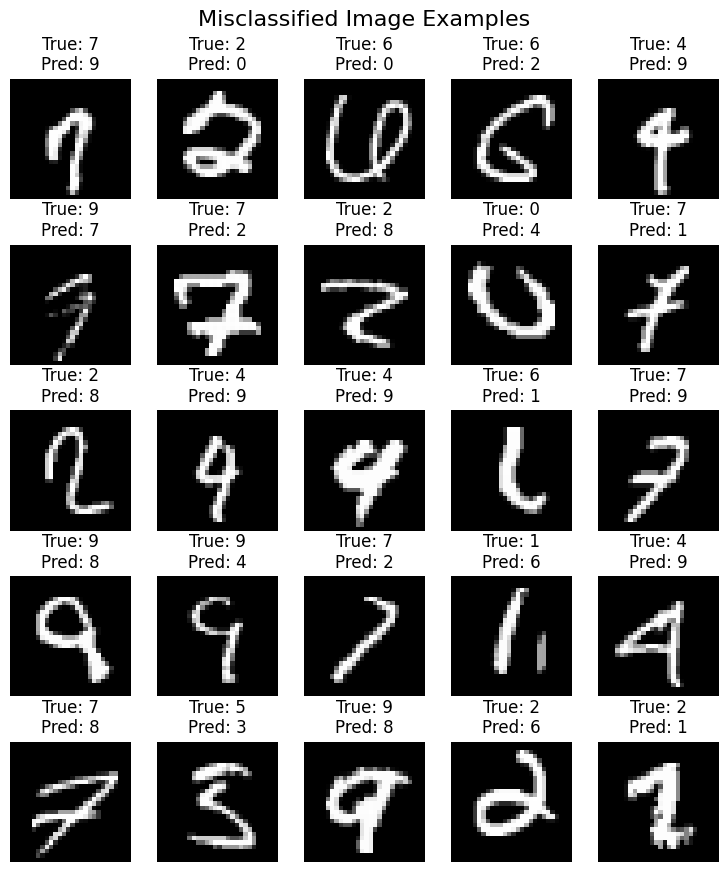


Evaluating on the test set for {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01} which took 26.920354
Test Accuracy: 0.9785
Found 215 misclassified images.


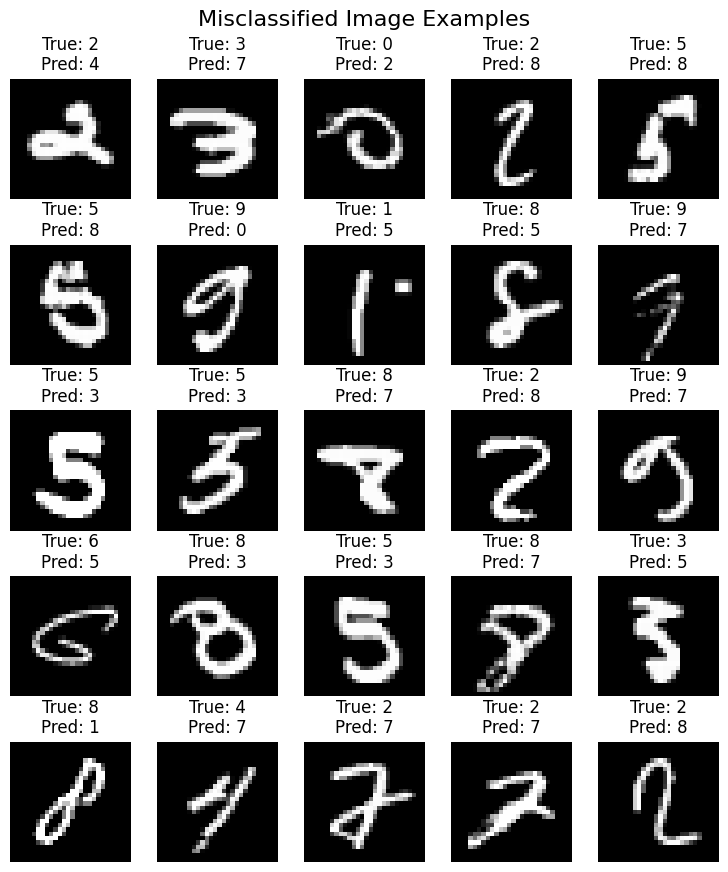


Evaluating on the test set for {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1} which took 27.011423
Test Accuracy: 0.9781
Found 219 misclassified images.


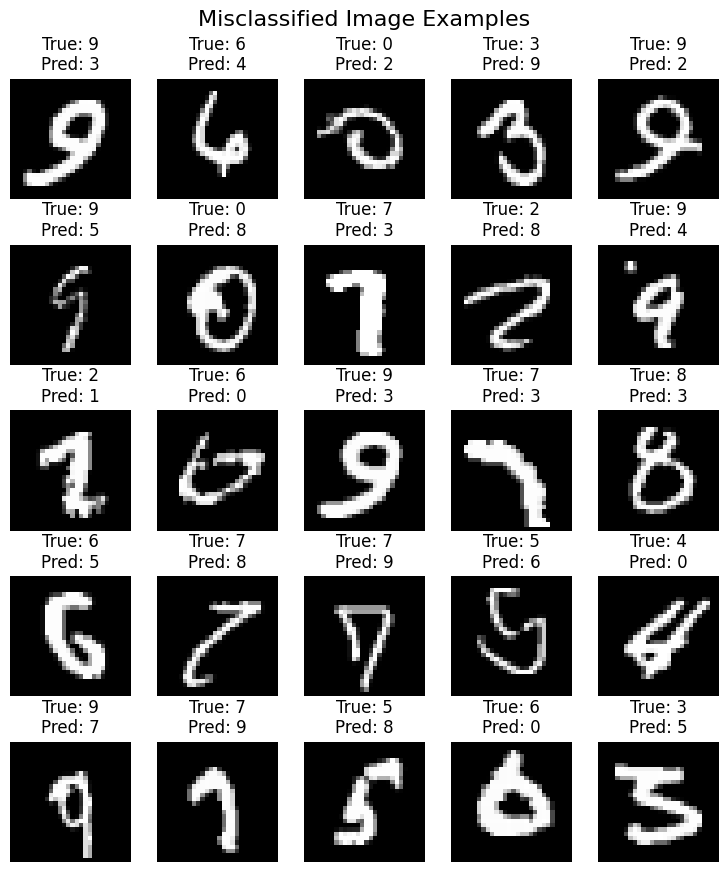


Evaluating on the test set for {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5} which took 26.629377
Test Accuracy: 0.9776
Found 224 misclassified images.


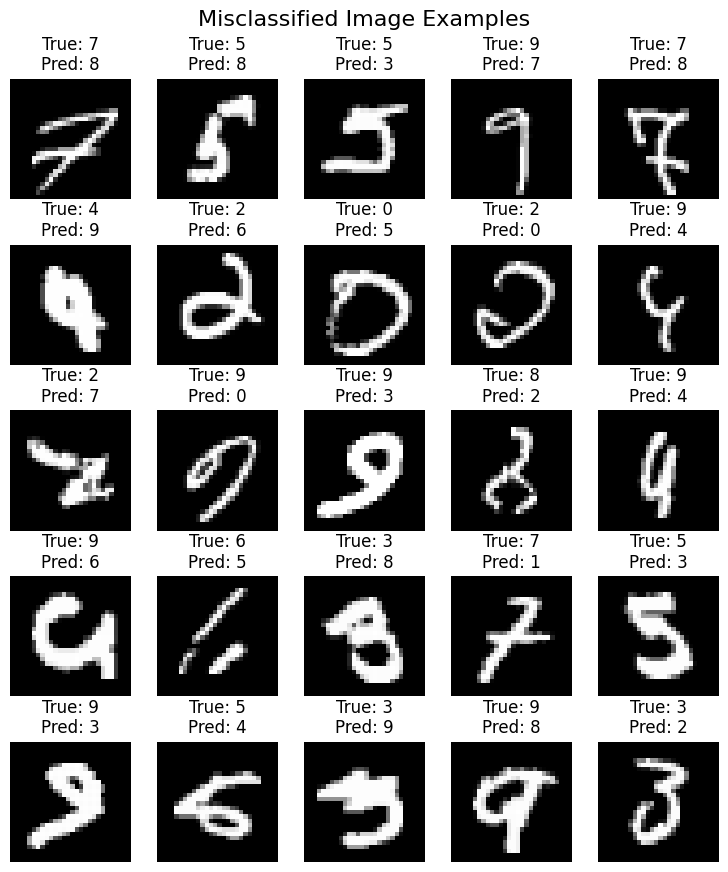

In [12]:
# Evaluate on the test set
for (mlp_configuration, trained_configurable_model, _, total_duration) in configurable_mlp_results:
    print(f"\nEvaluating on the test set for {mlp_configuration} which took {total_duration}")
    A2_test, _ = trained_configurable_model.forward_pass(X_test)
    predictions_test = get_predictions(A2_test)
    test_accuracy = get_accuracy(predictions_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_misclassified_images(X_test_orig=X_test_orig, y_test_orig=y_test_orig, y_pred=predictions_test)

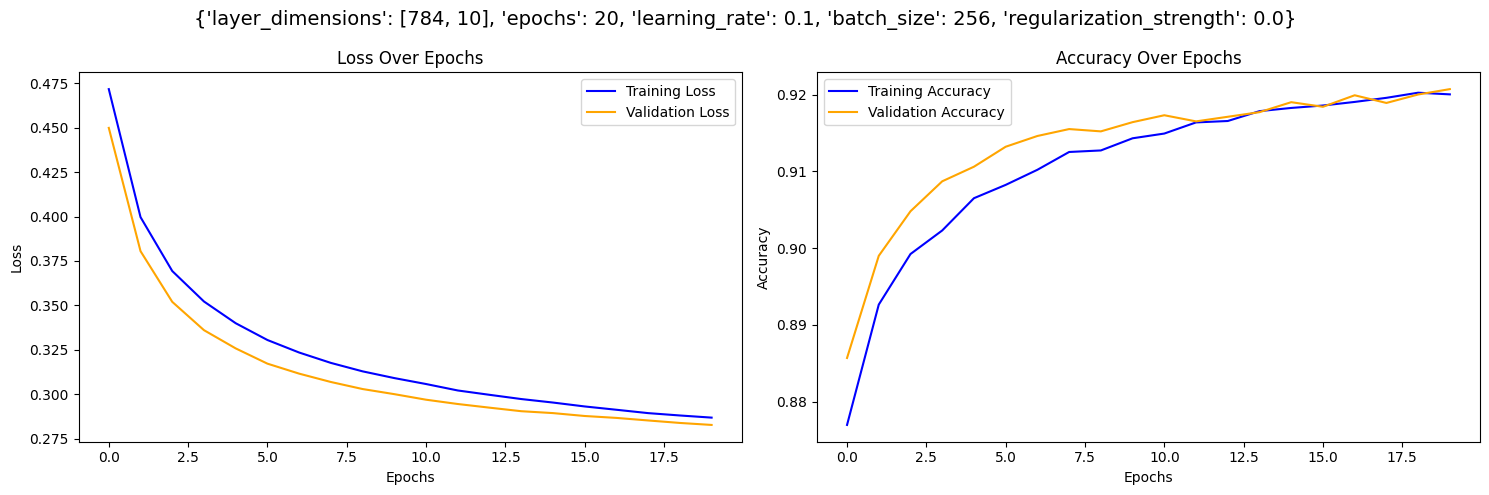

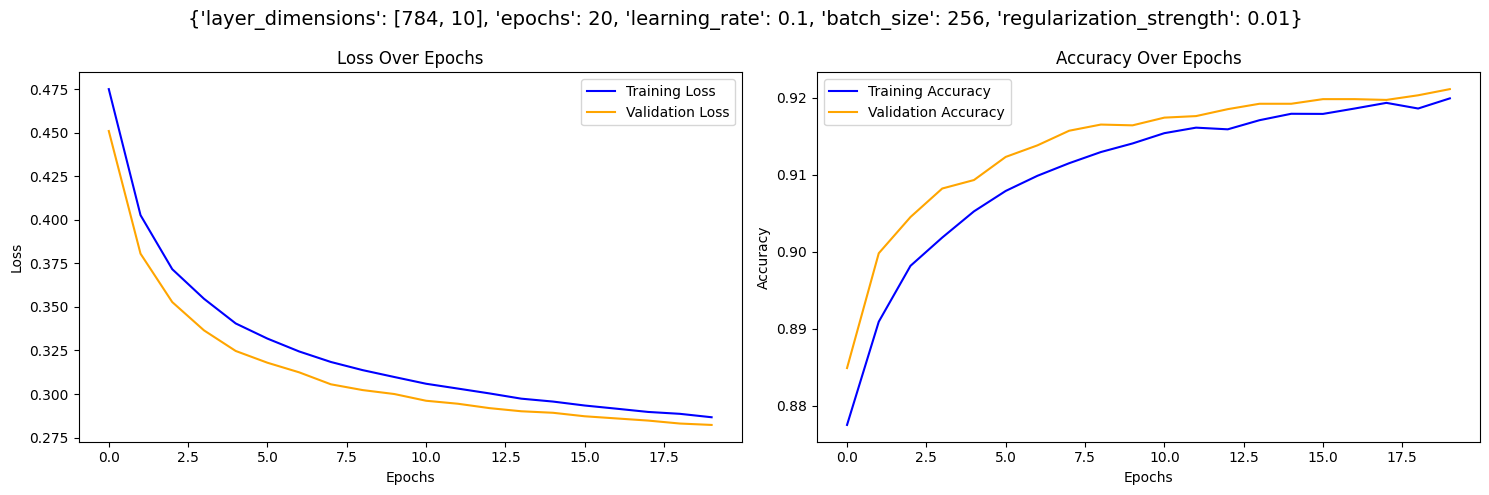

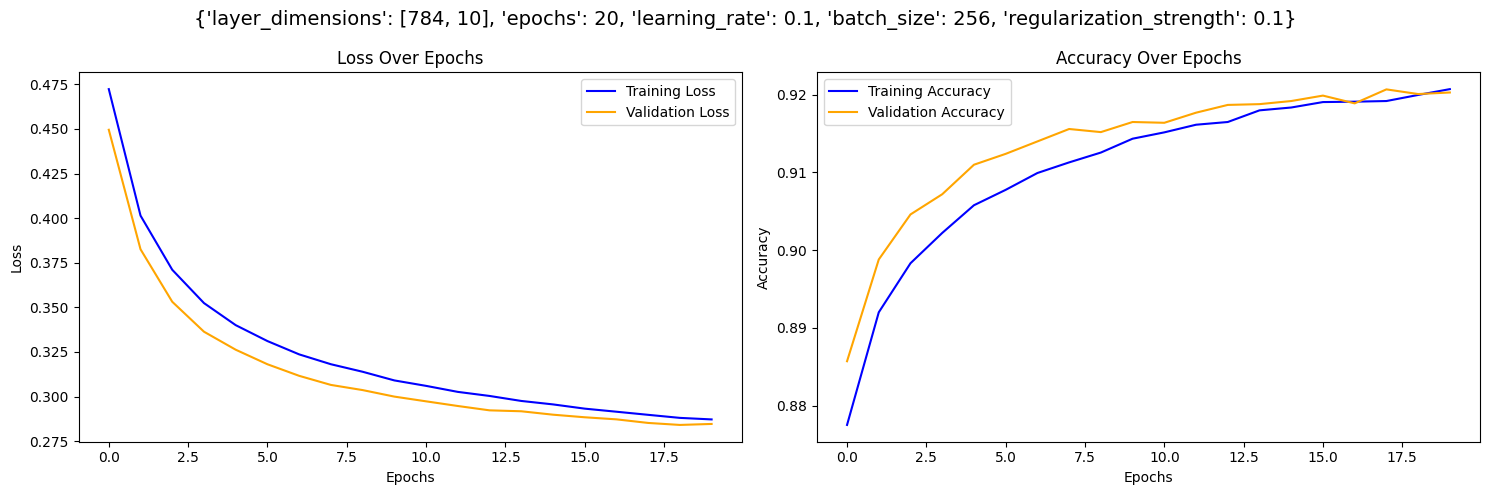

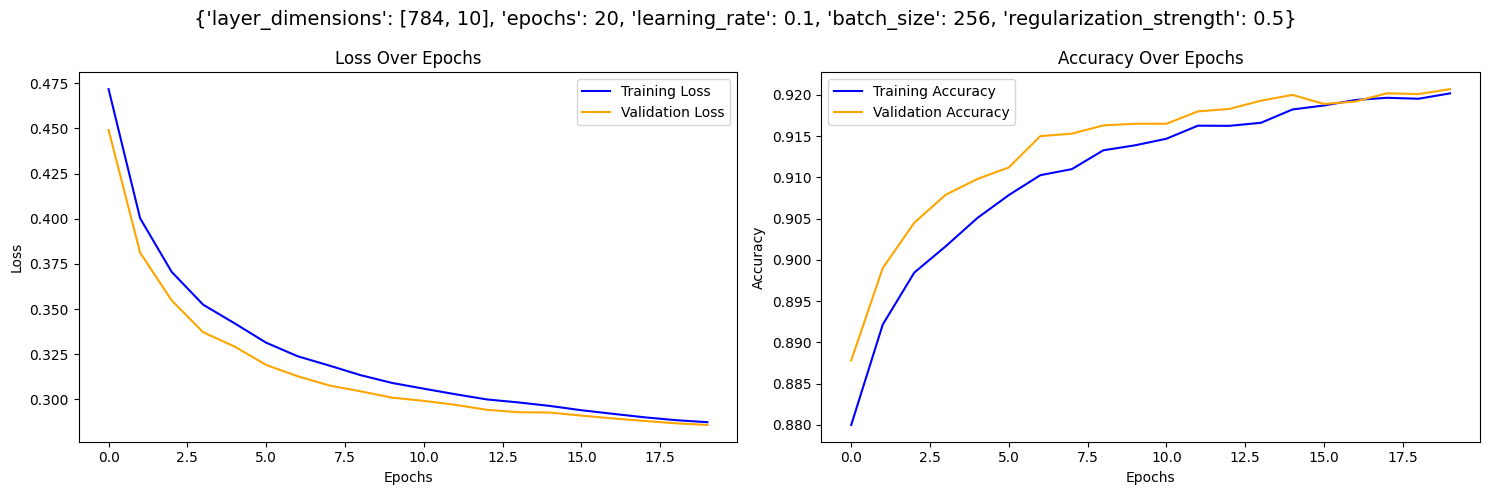

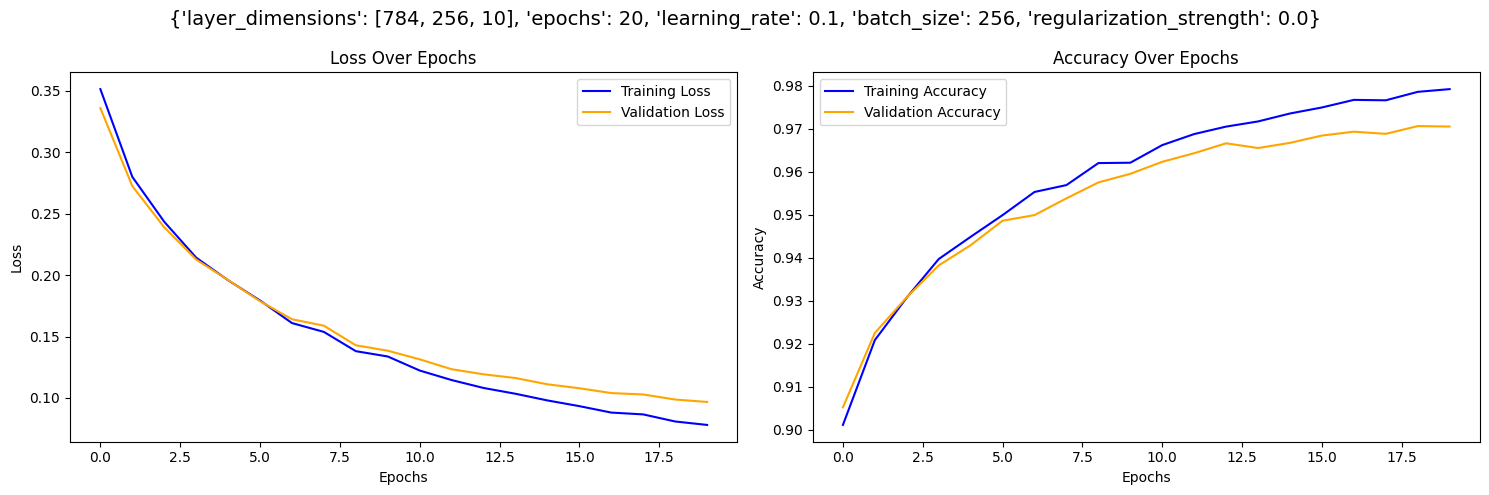

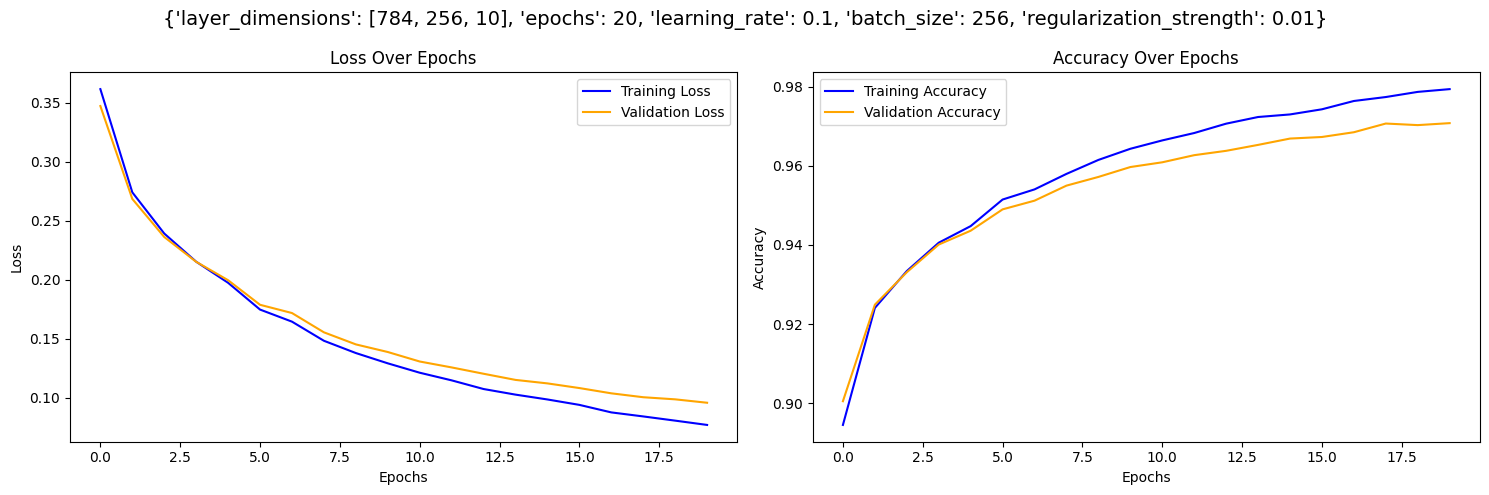

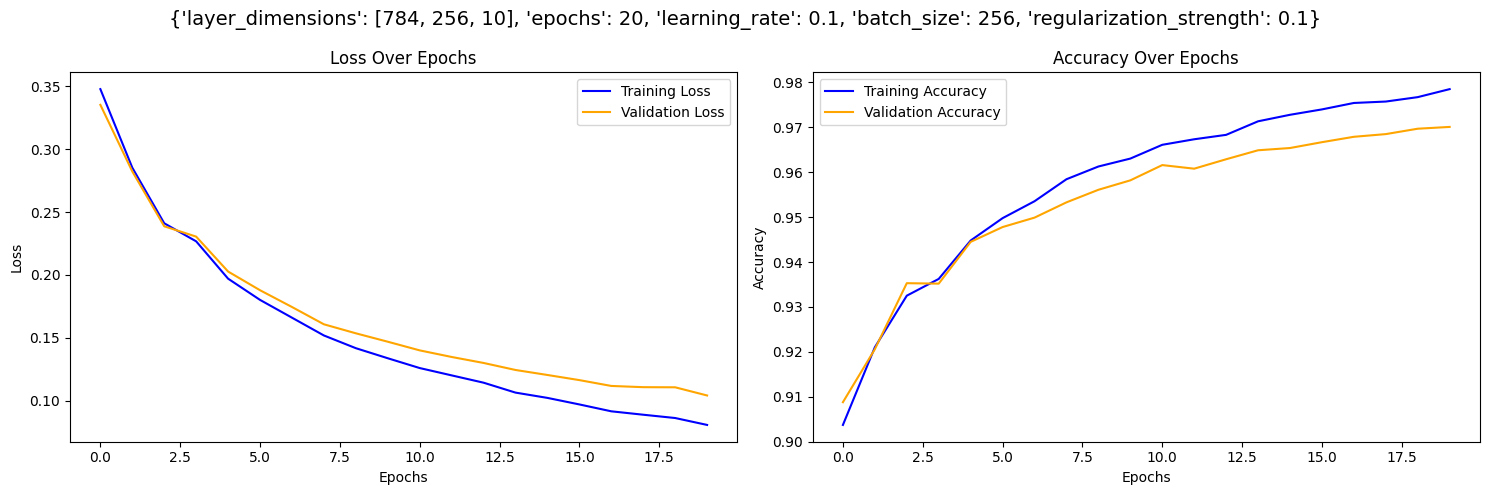

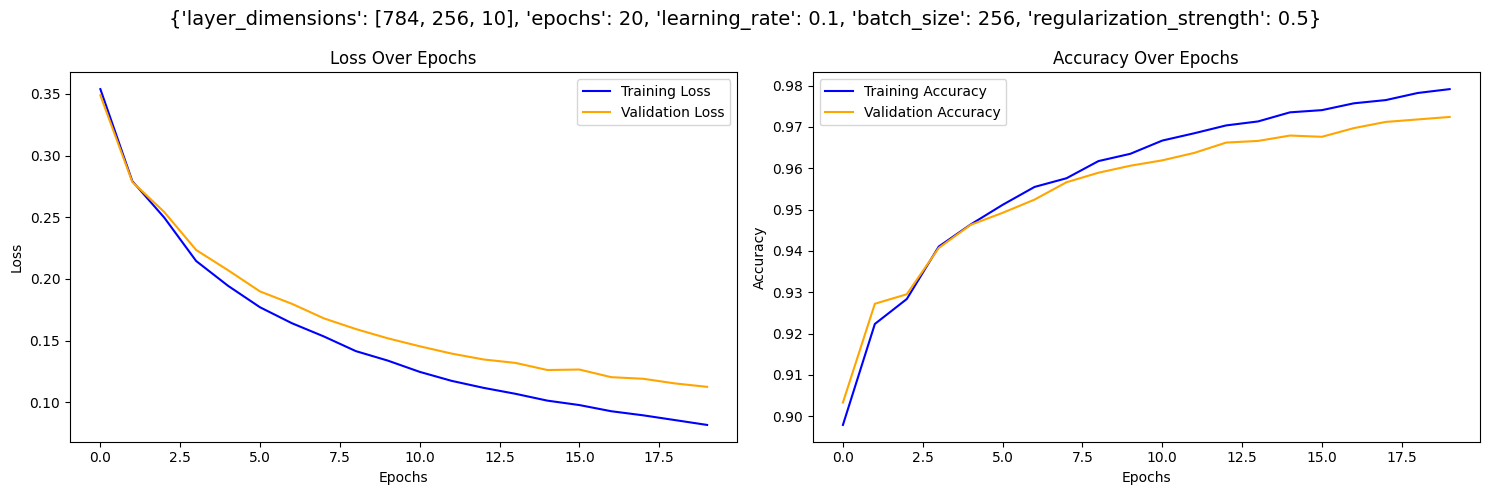

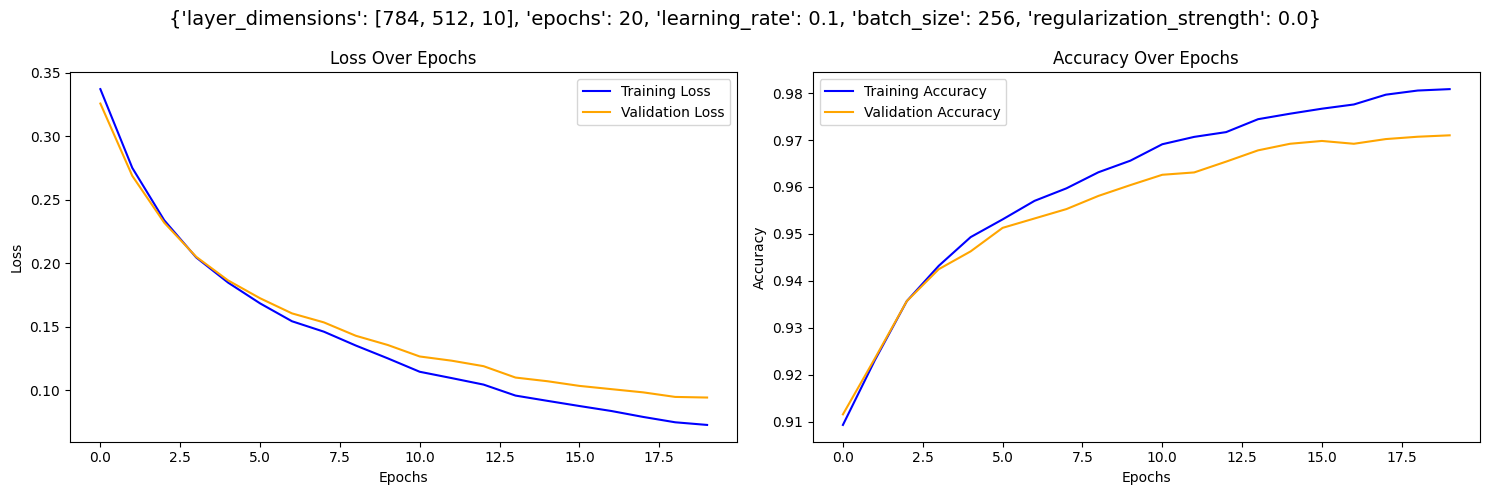

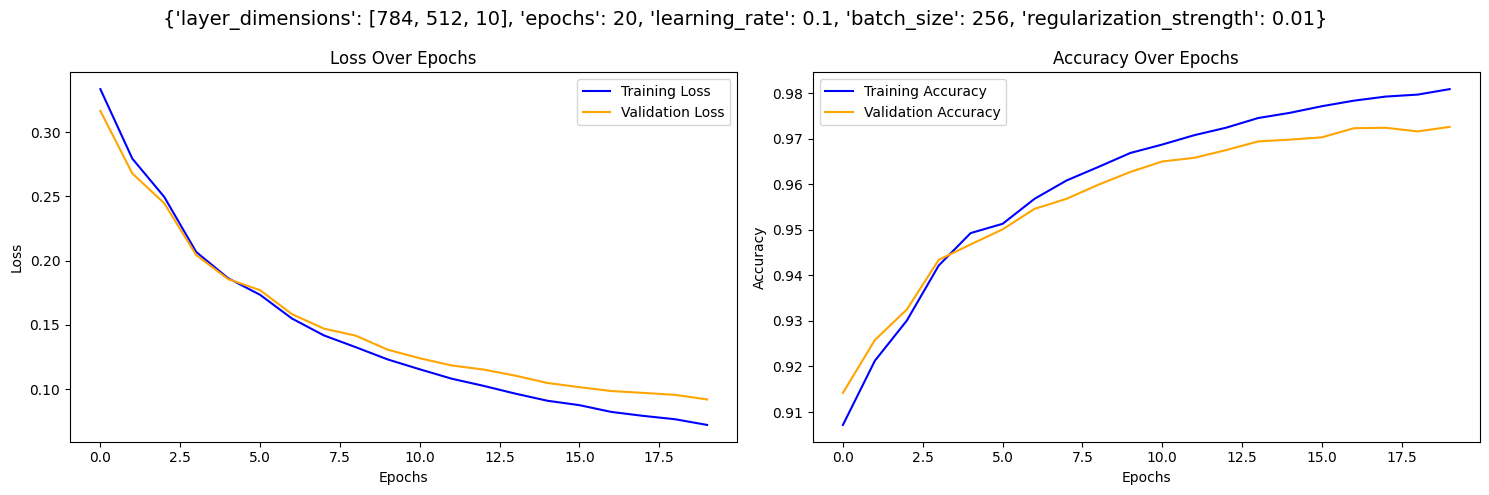

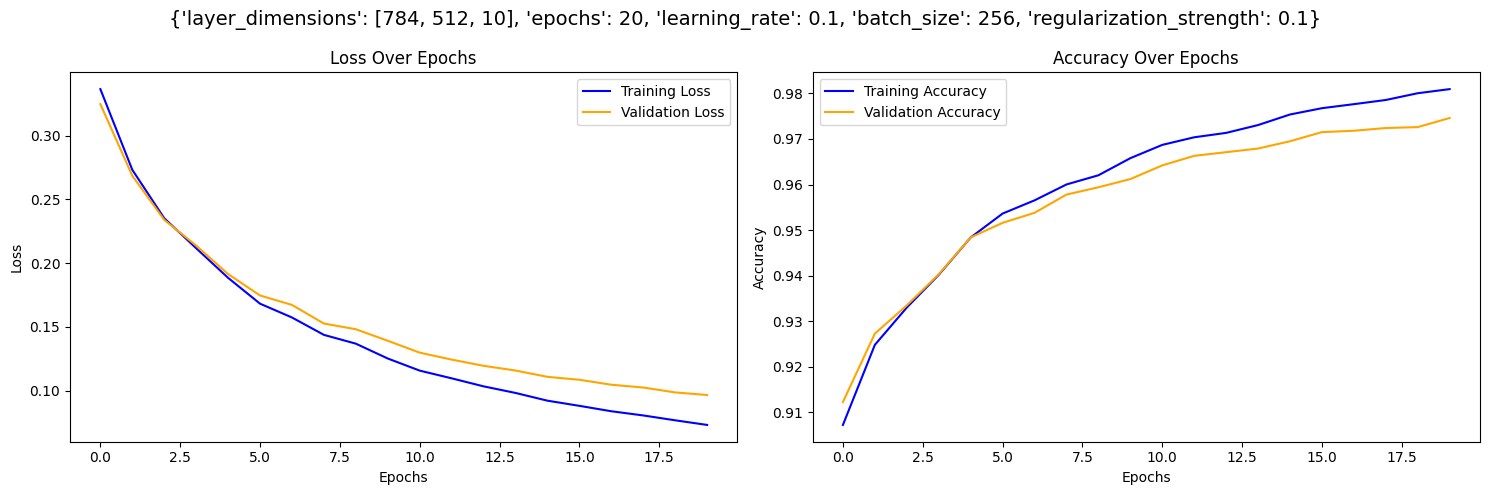

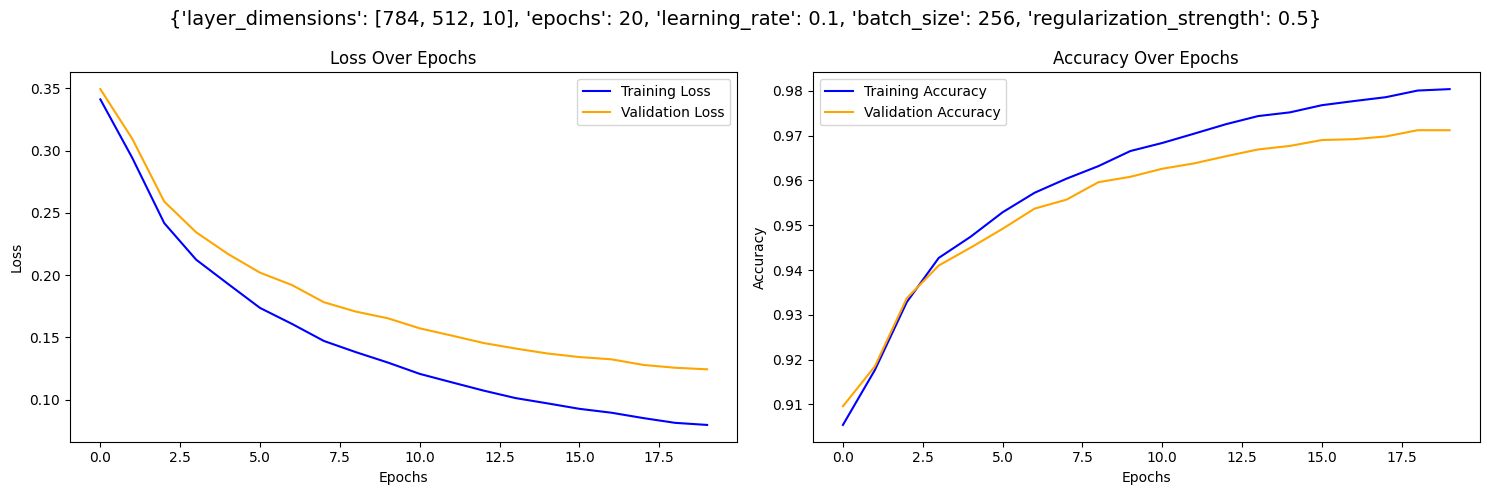

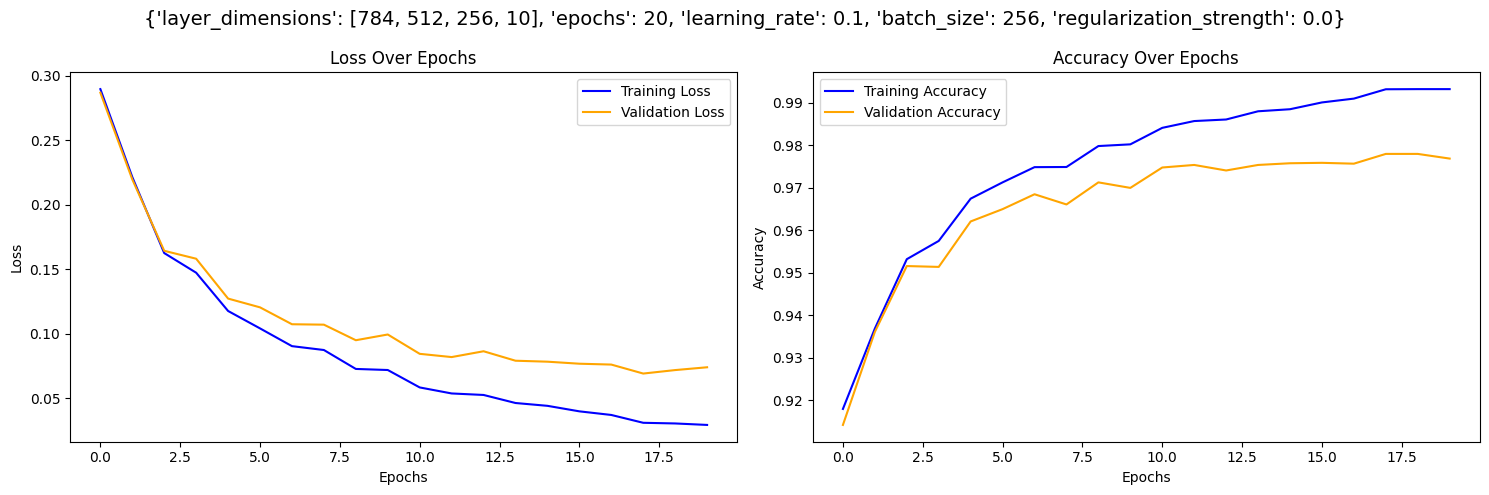

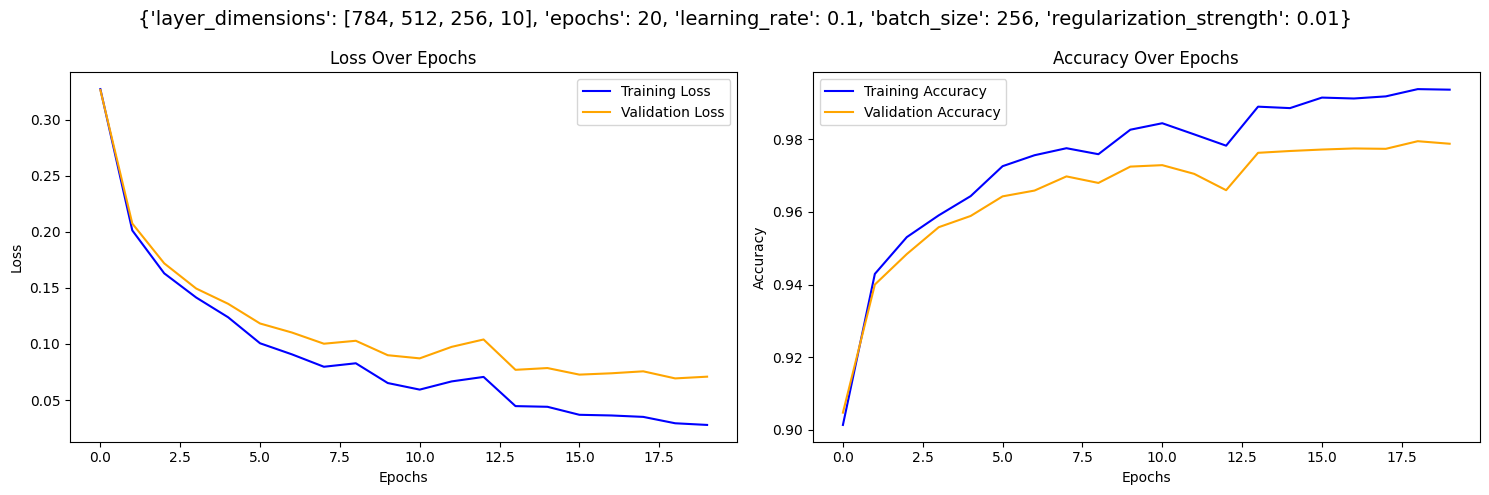

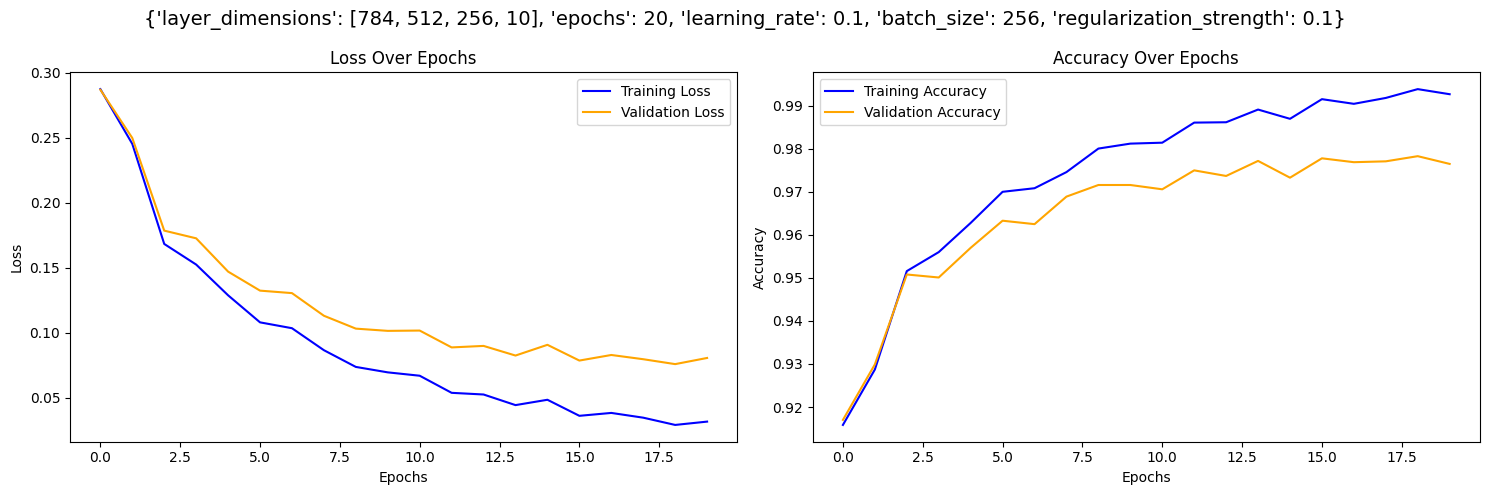

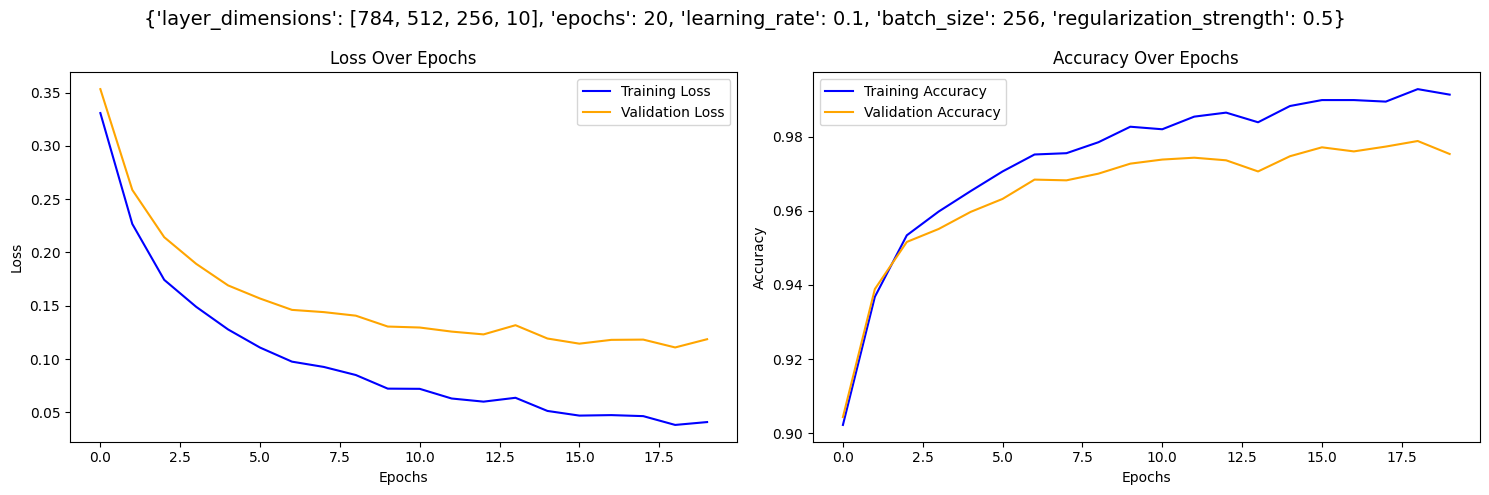

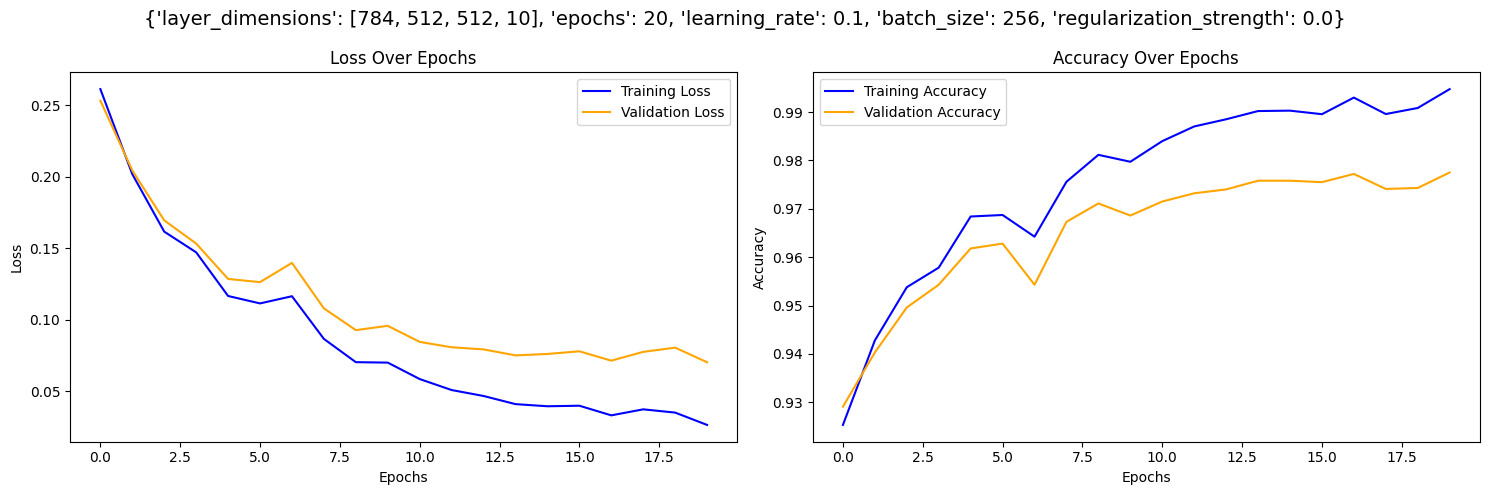

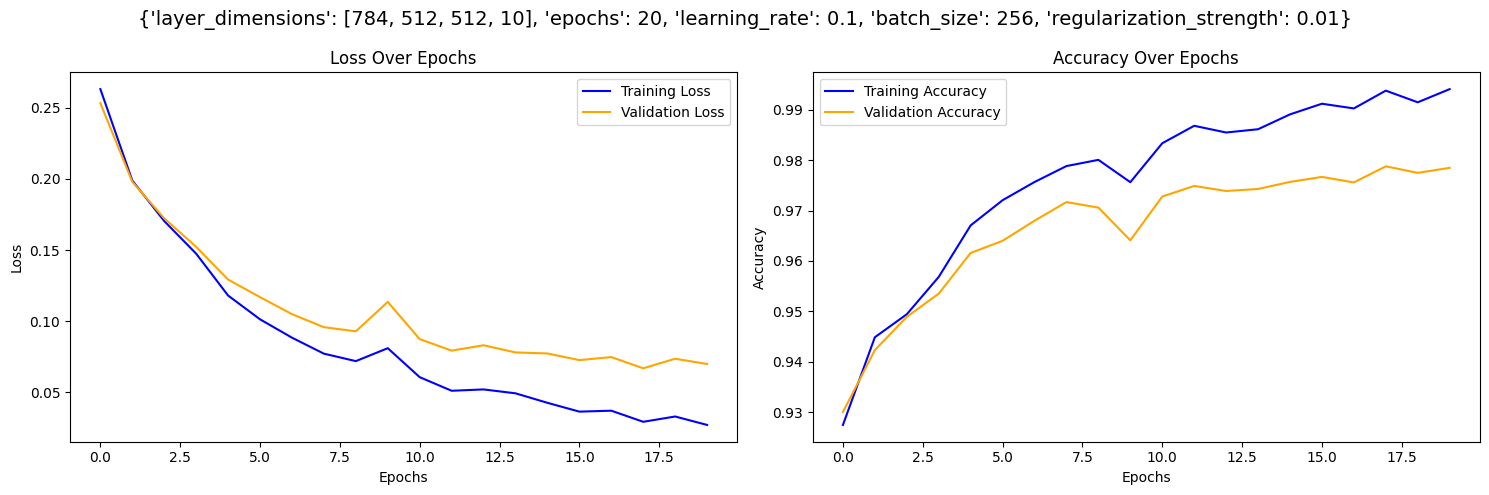

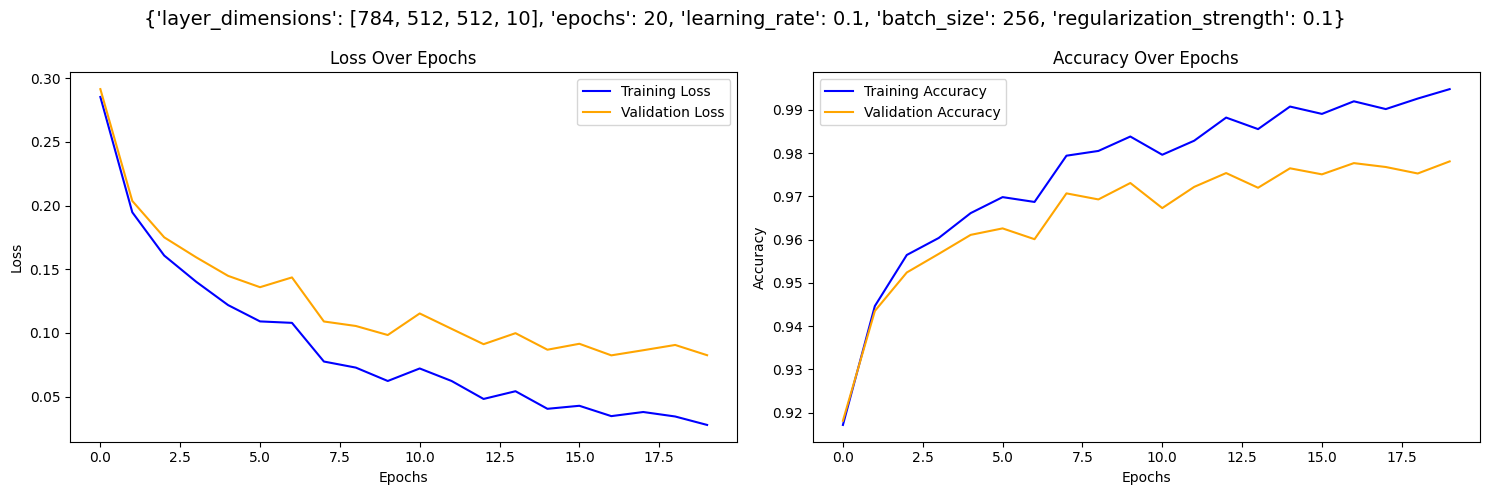

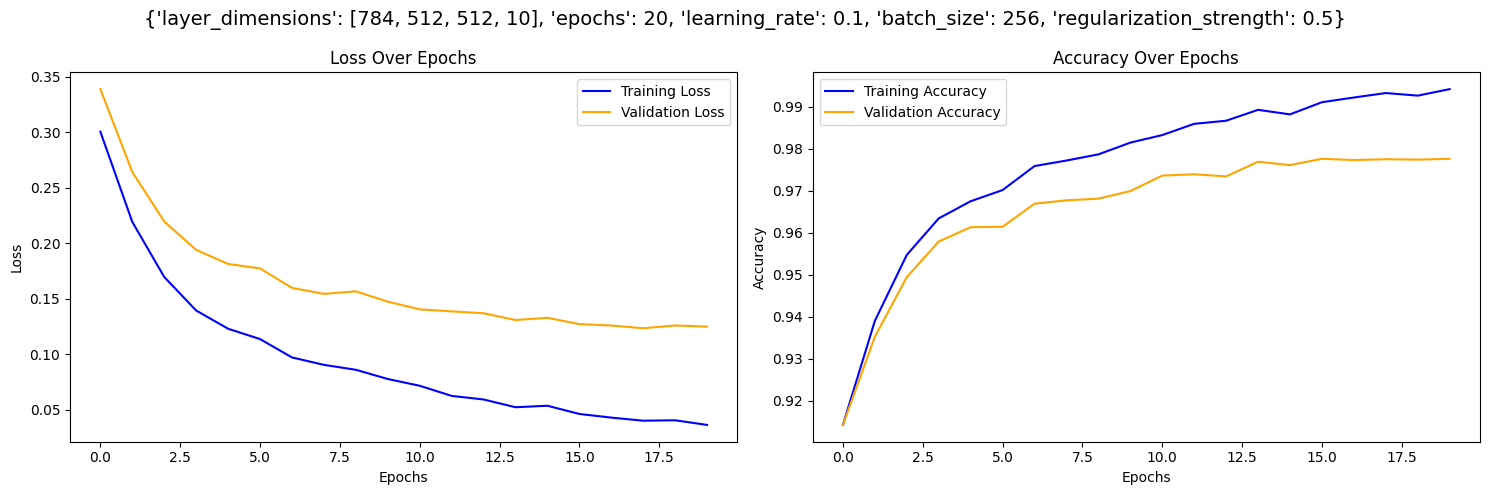

In [13]:
for (mlp_configuration, trained_configurable_model, training_history, total_duration) in configurable_mlp_results:
    plot_training_history(training_history, str(mlp_configuration))

In [23]:
# Image generation functions
# --- Main Visualization Function ---
def generate_ideal_image(
    model: ConfigurableMLP,
    target_digit: int,
    iterations: int = 500,
    learning_rate: float = 0.1,
    blur_sigma: float = 0.1,
    blur_frequency: int = 10,
) -> NDArray[np.float32]:
    """
    Generates an image that maximizes the activation for a target digit.
    """
    # 1. Create the target vector (e.g., [0, 0, 1, 0, ...])
    Y = np.zeros((10, 1), dtype=np.float32)
    Y[target_digit] = 1
    
    # 2. Start with a random noise image
    X = np.random.rand(784, 1).astype(np.float32)

    # 3. Perform gradient ascent
    for i in range(iterations):
        # Forward pass to get the current prediction and caches
        AL, caches = model.forward_pass(X)
        
        # Backward pass to get the gradient for the input pixels
        dX = model.get_input_gradient(AL, Y, caches)

        # --- KEY ADDITION: Normalize the gradient ---
        # Add a small epsilon to avoid division by zero
        dX /= (np.std(dX) + 1e-8) 
        
        # Update the image using the gradient (ascent, so we add)
        X += learning_rate * dX

        # --- APPLY GAUSSIAN BLUR ---
        # Apply the blur periodically to enforce smoothness
        if i > 0 and i % blur_frequency == 0 and blur_sigma > 0:
            # Reshape the flat vector (784, 1) into a 2D image (28, 28)
            image_2d = X.reshape(28, 28)
            
            # Apply the Gaussian filter
            blurred_image_2d = gaussian_filter(image_2d, sigma=blur_sigma)
            
            # Reshape the blurred image back to a flat vector for the next loop
            X = blurred_image_2d.reshape(784, 1)
        
        # Clip the pixel values to stay within the valid [0, 1] range
        X = np.clip(X, 0, 1)

    return X.reshape(28, 28)

def generate_images(model: ConfigurableMLP, configuration: MLPConfiguration):
    """
    Generates and visualizes a model's 'ideal' image for each digit,
    annotating each image with the model's prediction and confidence.
    """
    print(f"Generating images for configuration: {configuration}")
    fig, axes = plt.subplots(2, 5, figsize=(12, 6.5))
    axes = axes.flatten()

    for digit in range(10):
        ax = axes[digit]
        
        # --- Image Generation and Classification ---
        ideal_image = generate_ideal_image(
            model,
            digit,
            iterations=2_000 * len(configuration.layer_dimensions),
            learning_rate=0.0005
        )
        probabilities, _ = model.forward_pass(ideal_image.reshape(784, 1))
        predicted_class = np.argmax(probabilities)
        confidence = np.max(probabilities)

        # --- Plotting ---
        ax.imshow(ideal_image, cmap='viridis')
        ax.axis('off')
        
        # Set a clean title showing only the target digit
        ax.set_title(f"Target: {digit}", fontsize=16, y=1.0)

        # Add text directly on the image for the prediction details
        # The bbox creates a semi-transparent background for readability
        text_label = f"Pred: {predicted_class} ({confidence:.1%})"
        ax.text(
            0.05, 0.05, text_label,
            color='white',
            fontsize=11,
            fontweight='bold',
            ha='left',
            va='bottom',
            transform=ax.transAxes, # Position relative to the subplot frame
            bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.6, edgecolor='none')
        )

    # Use a tight layout and a main title for the entire figure
    fig.suptitle(f"Network's 'Ideal' Vision of Each Digit {configuration}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    plt.show()


Generating images for configuration: {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0}


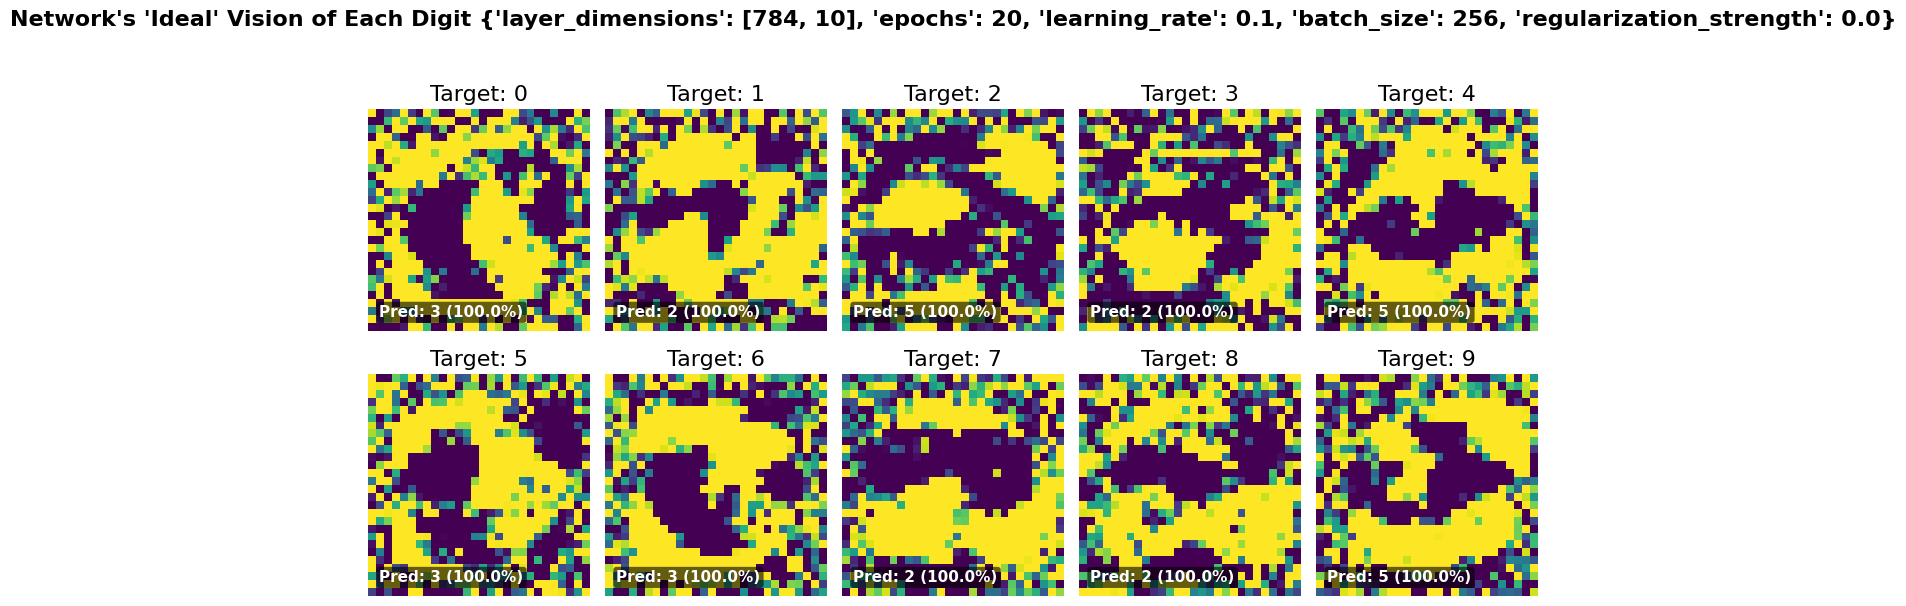

Generating images for configuration: {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01}


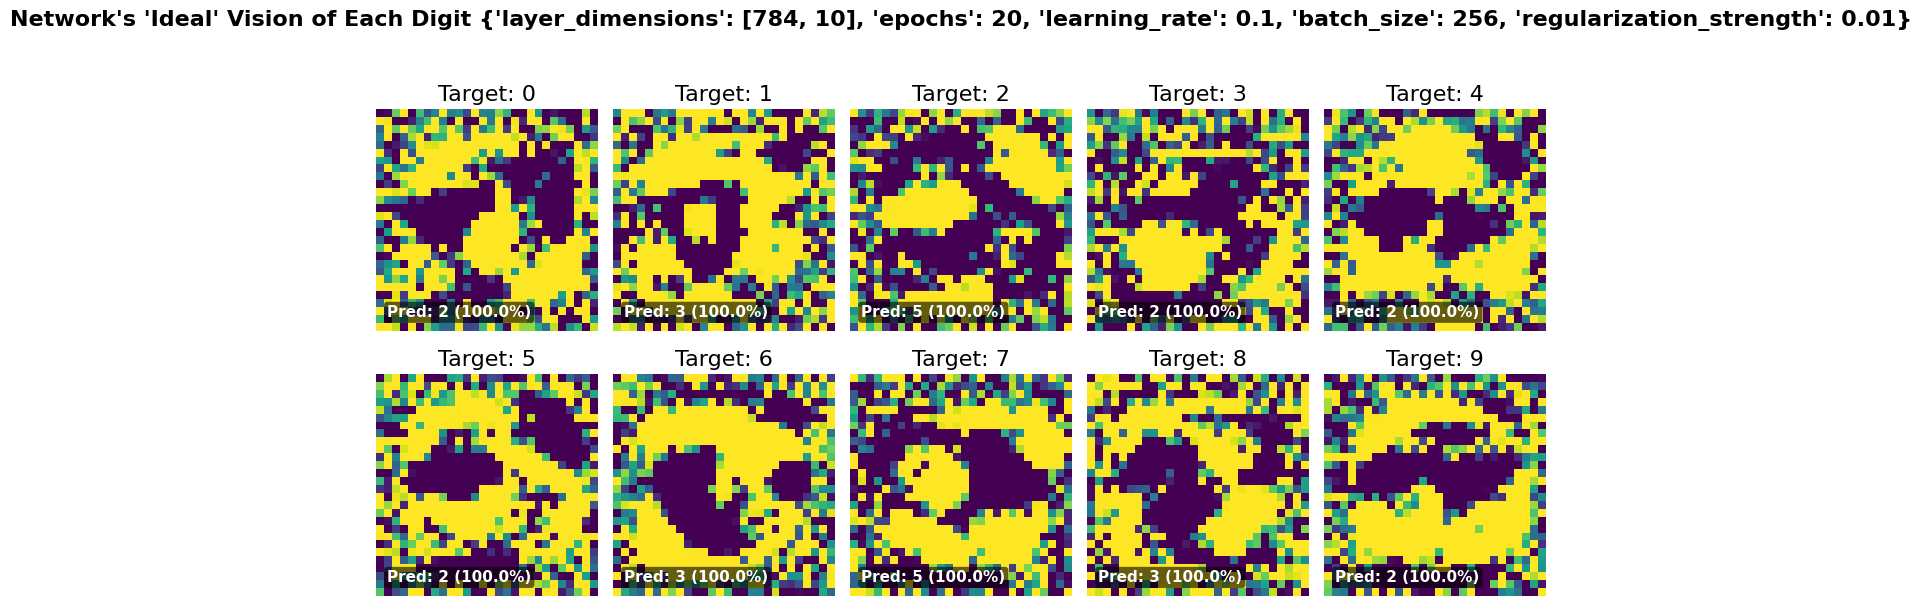

Generating images for configuration: {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1}


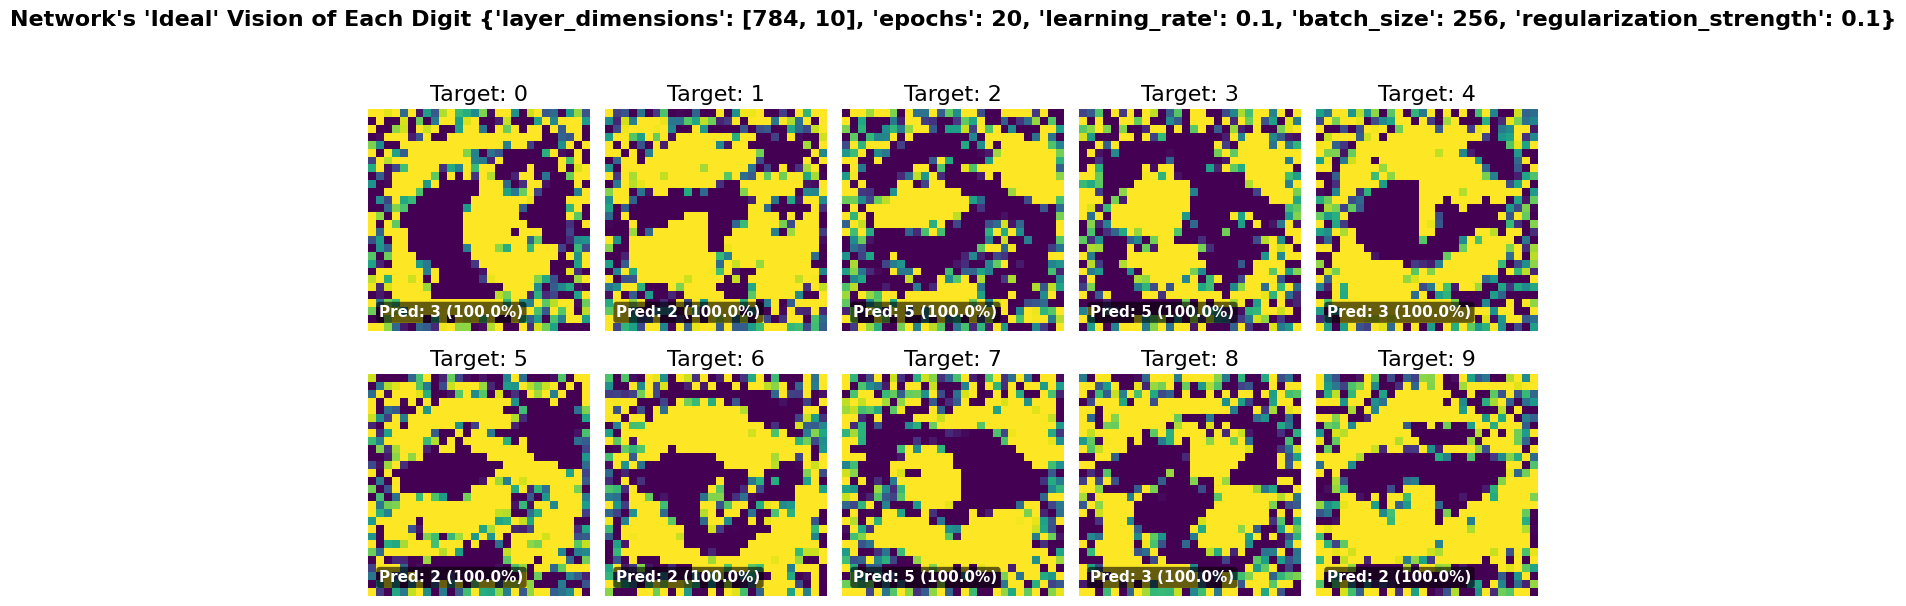

Generating images for configuration: {'layer_dimensions': [784, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5}


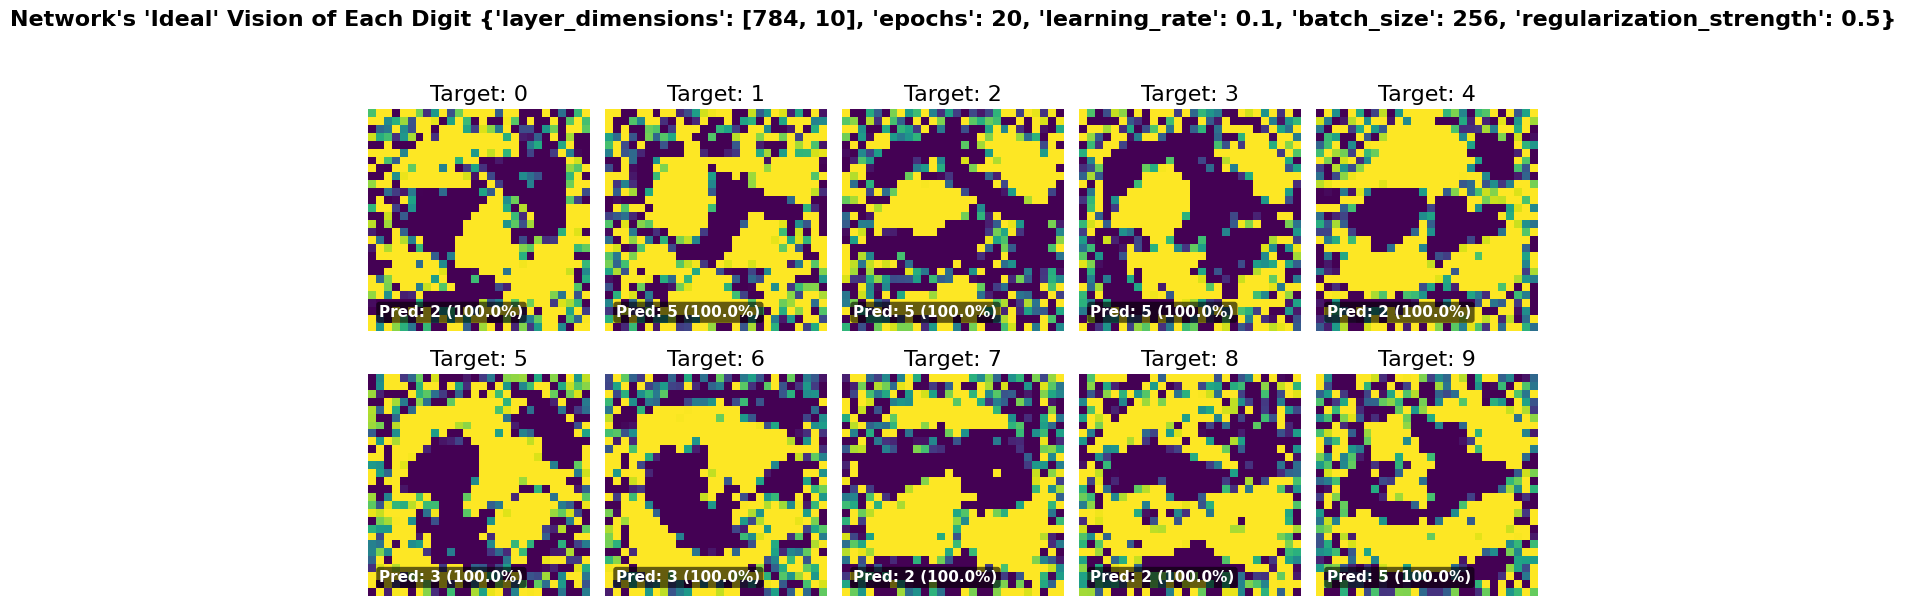

Generating images for configuration: {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0}


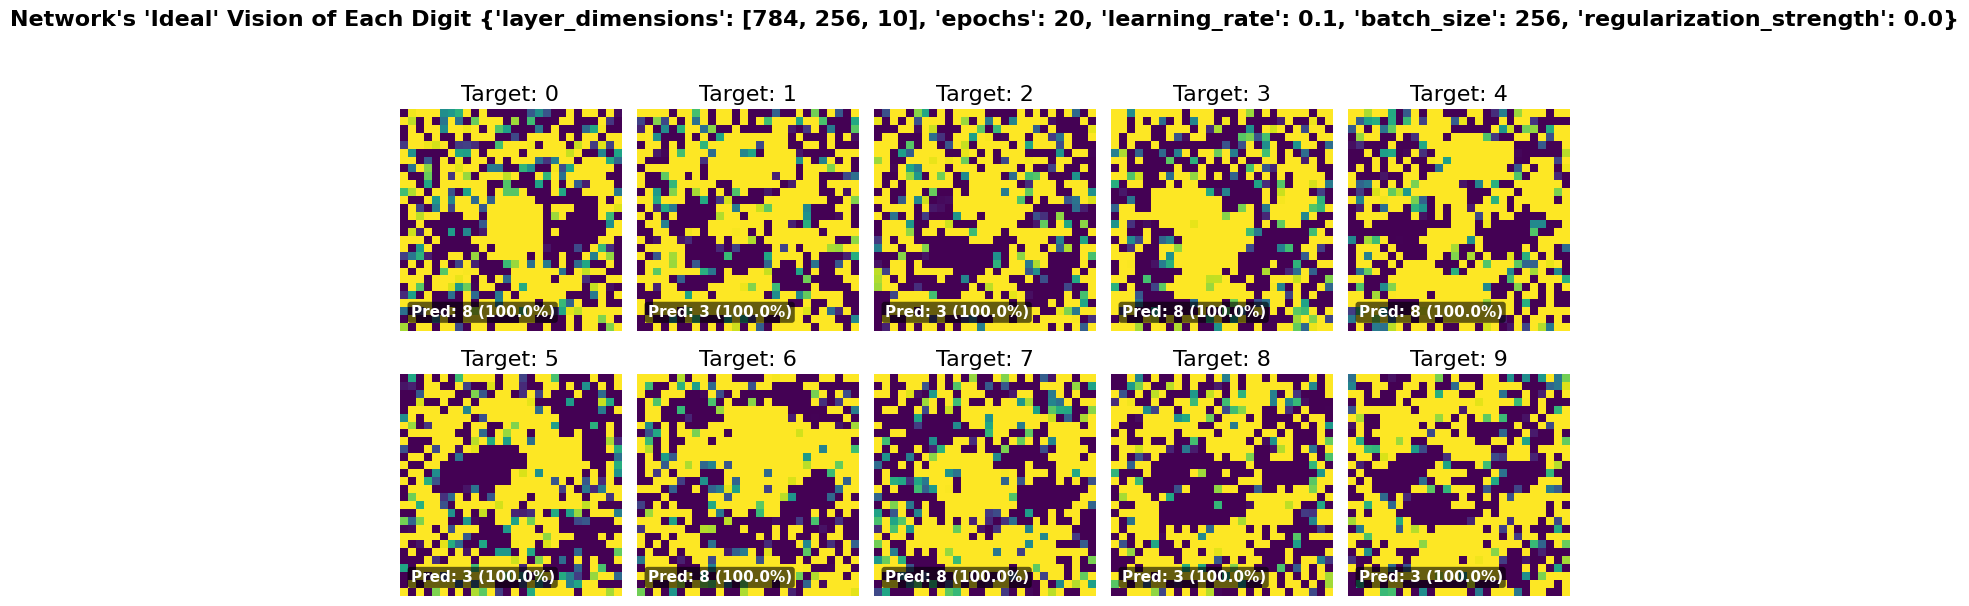

Generating images for configuration: {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01}


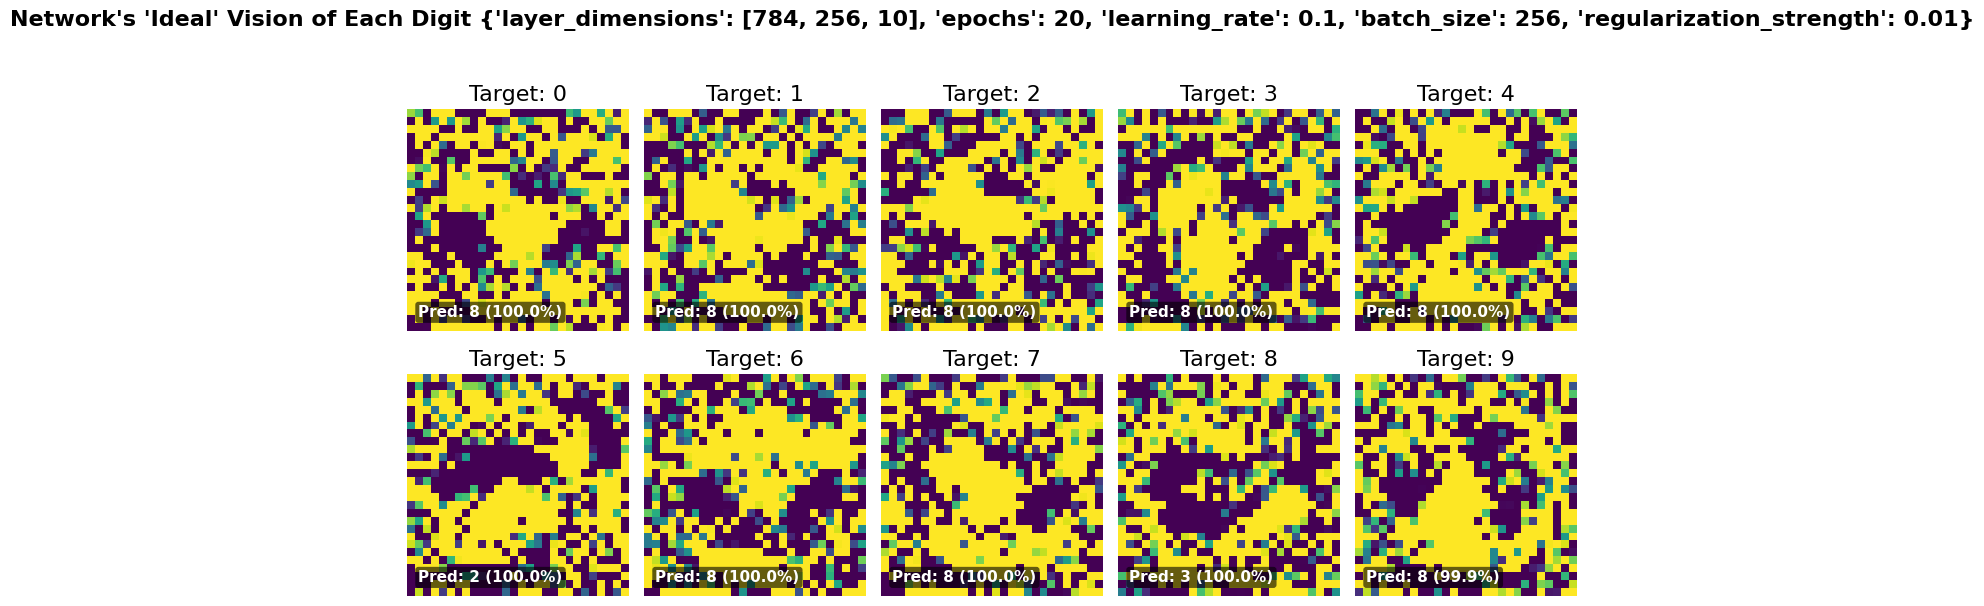

Generating images for configuration: {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1}


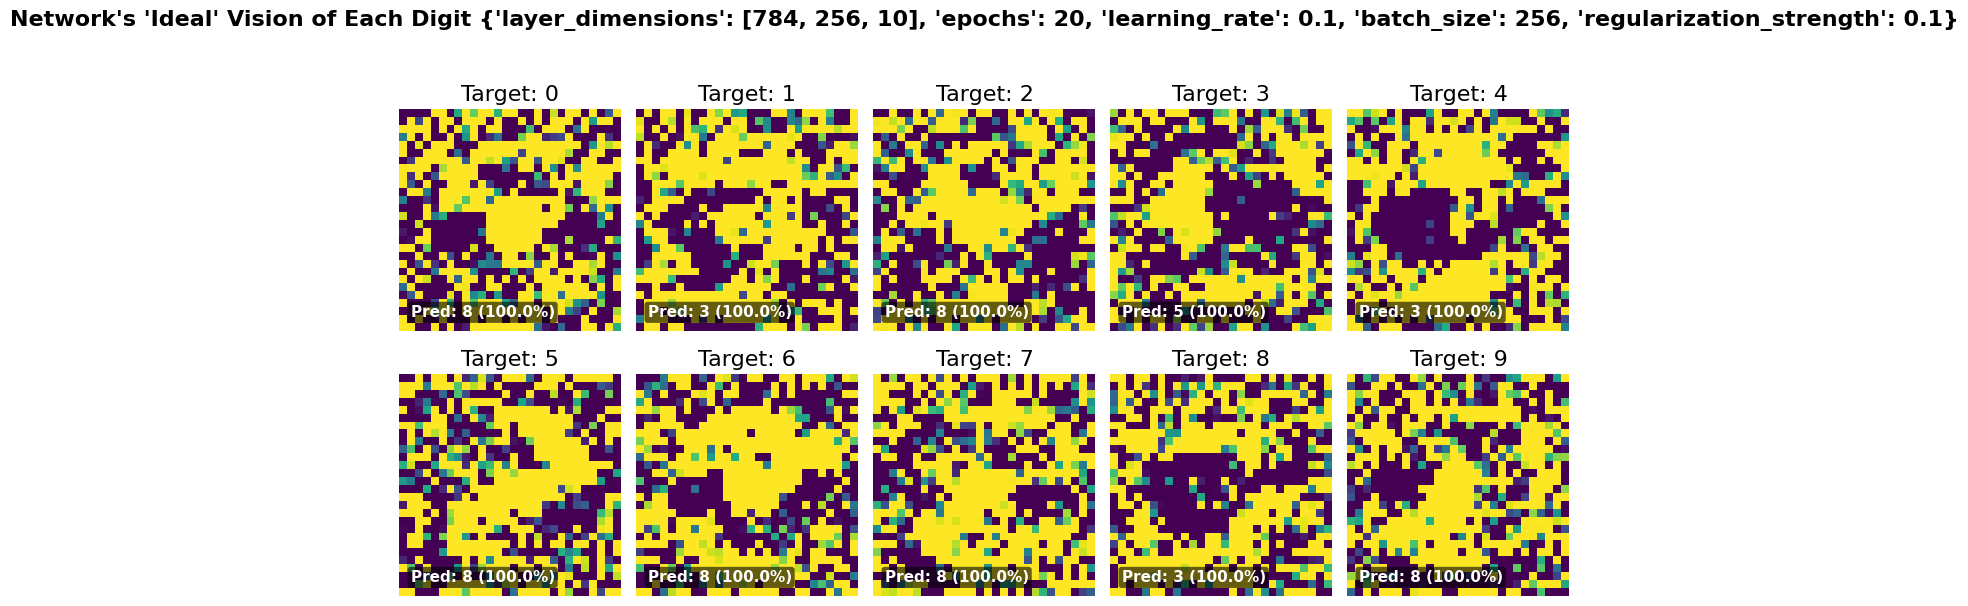

Generating images for configuration: {'layer_dimensions': [784, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5}


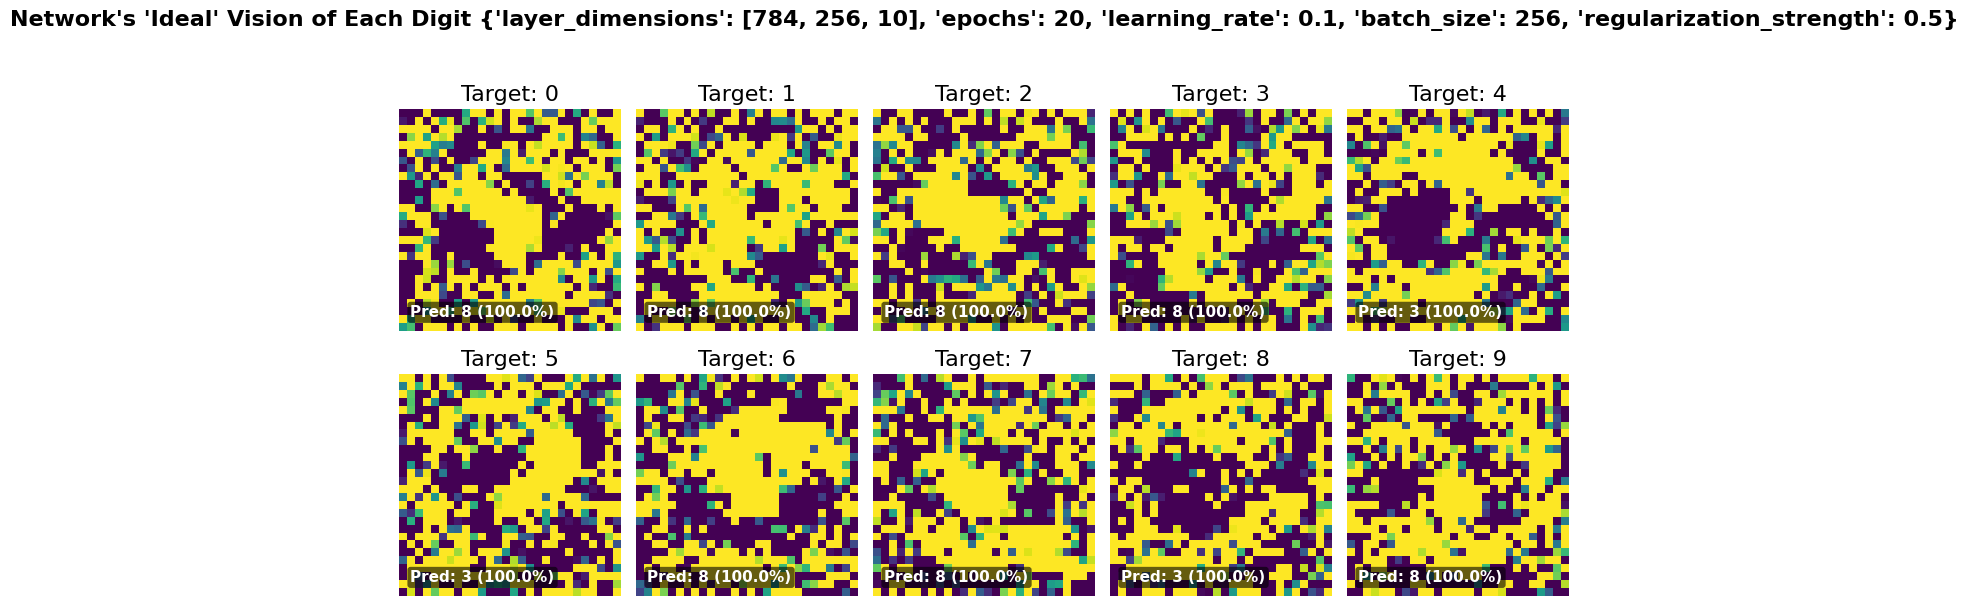

Generating images for configuration: {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0}


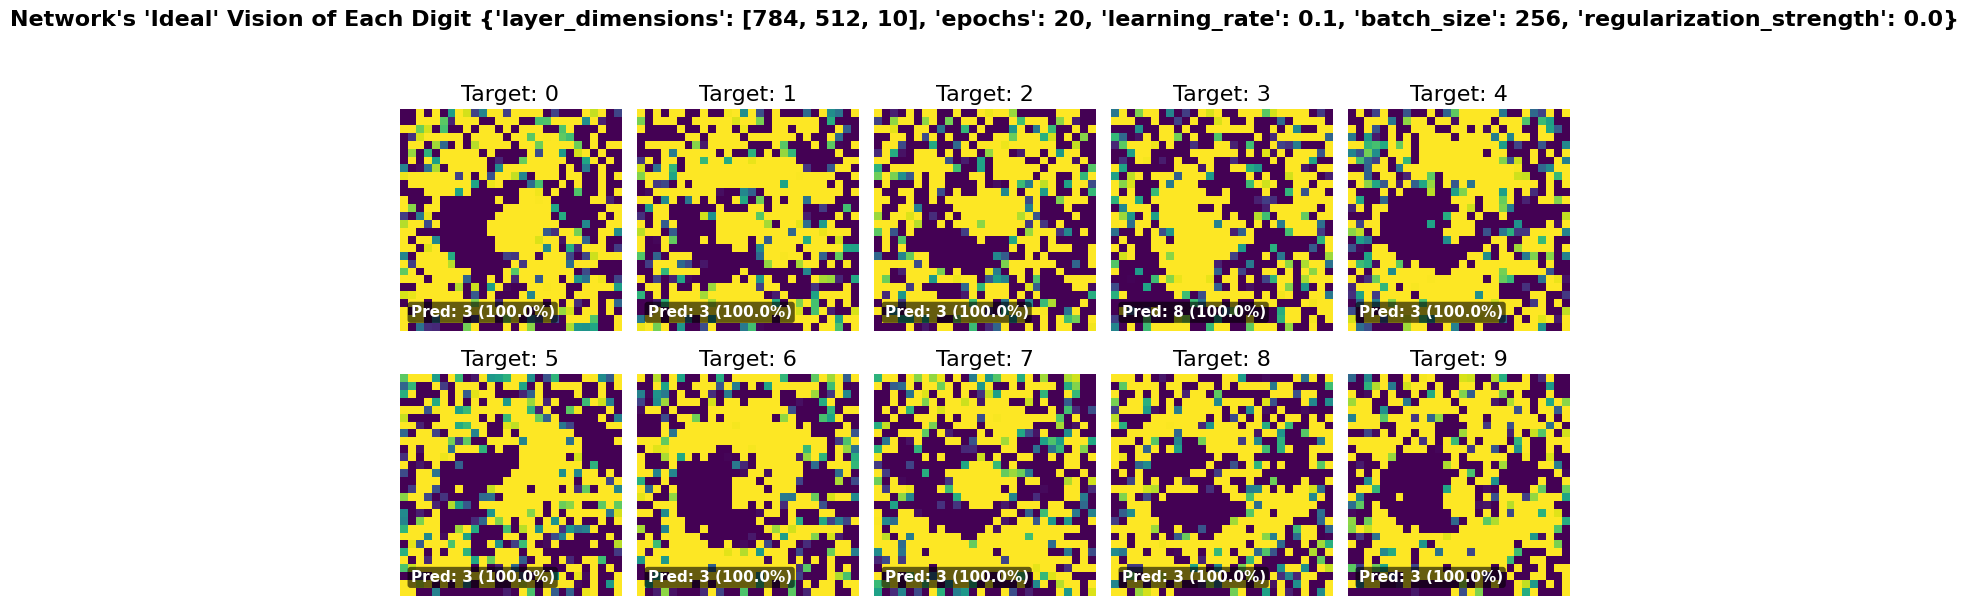

Generating images for configuration: {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01}


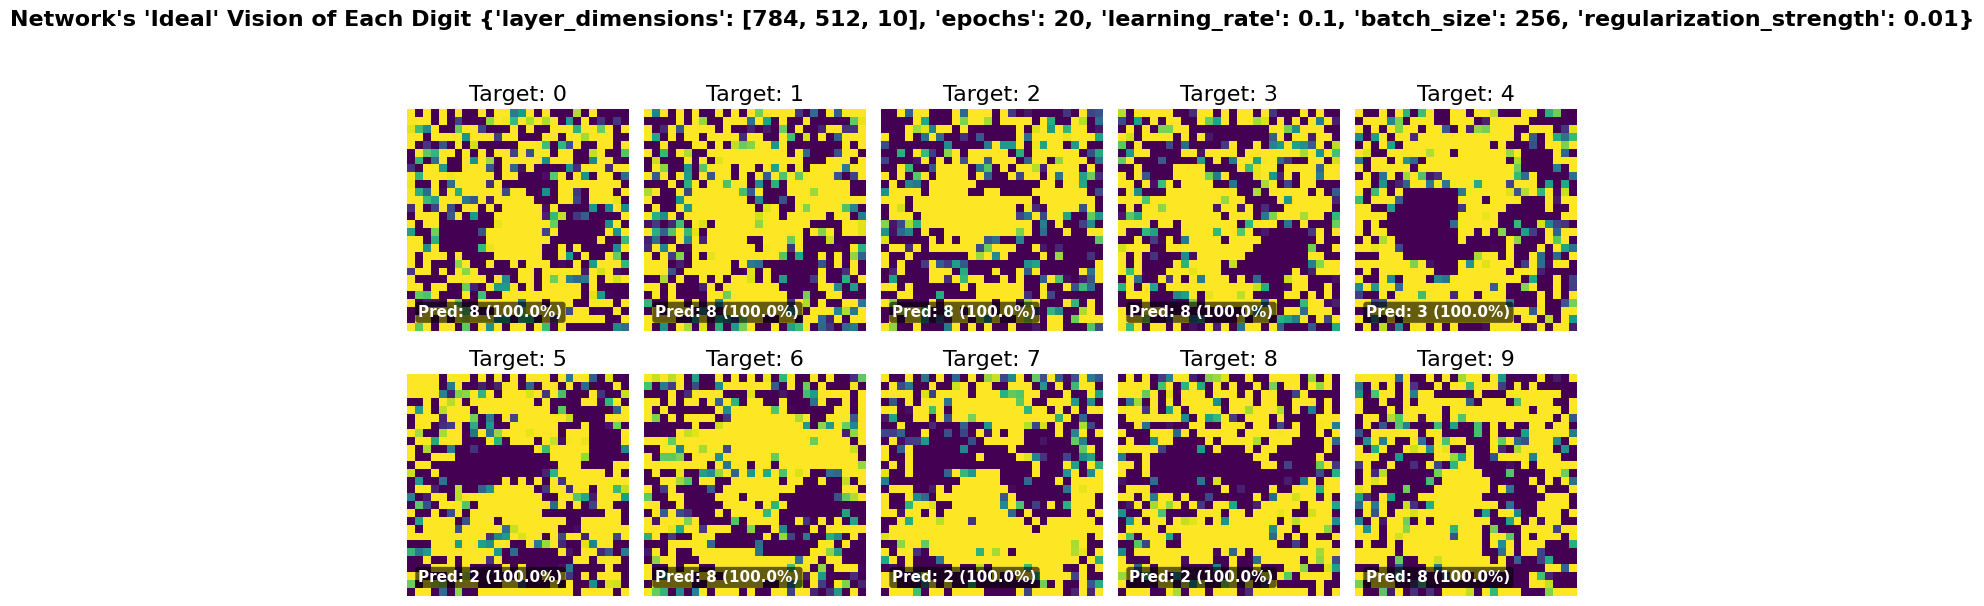

Generating images for configuration: {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1}


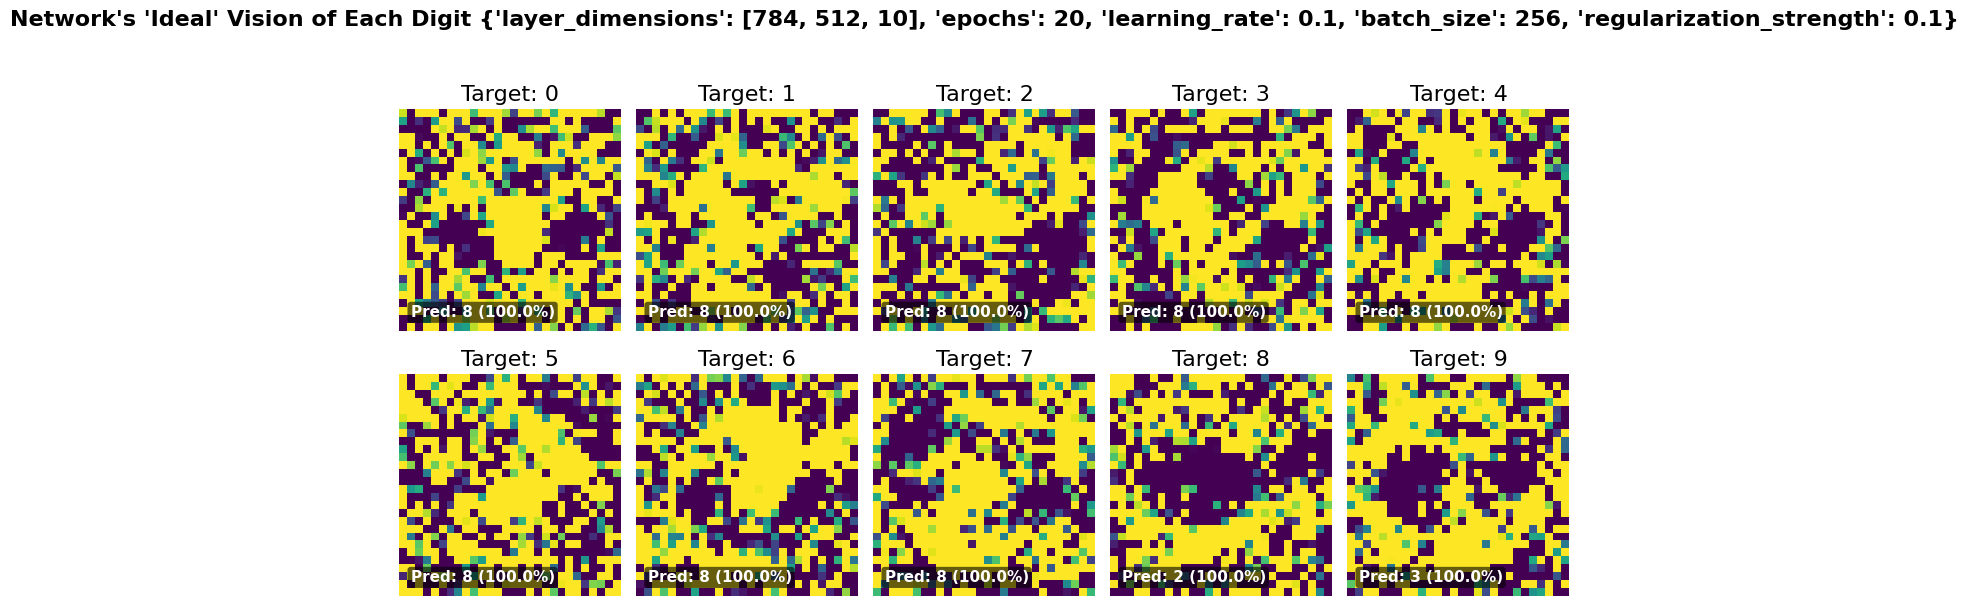

Generating images for configuration: {'layer_dimensions': [784, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5}


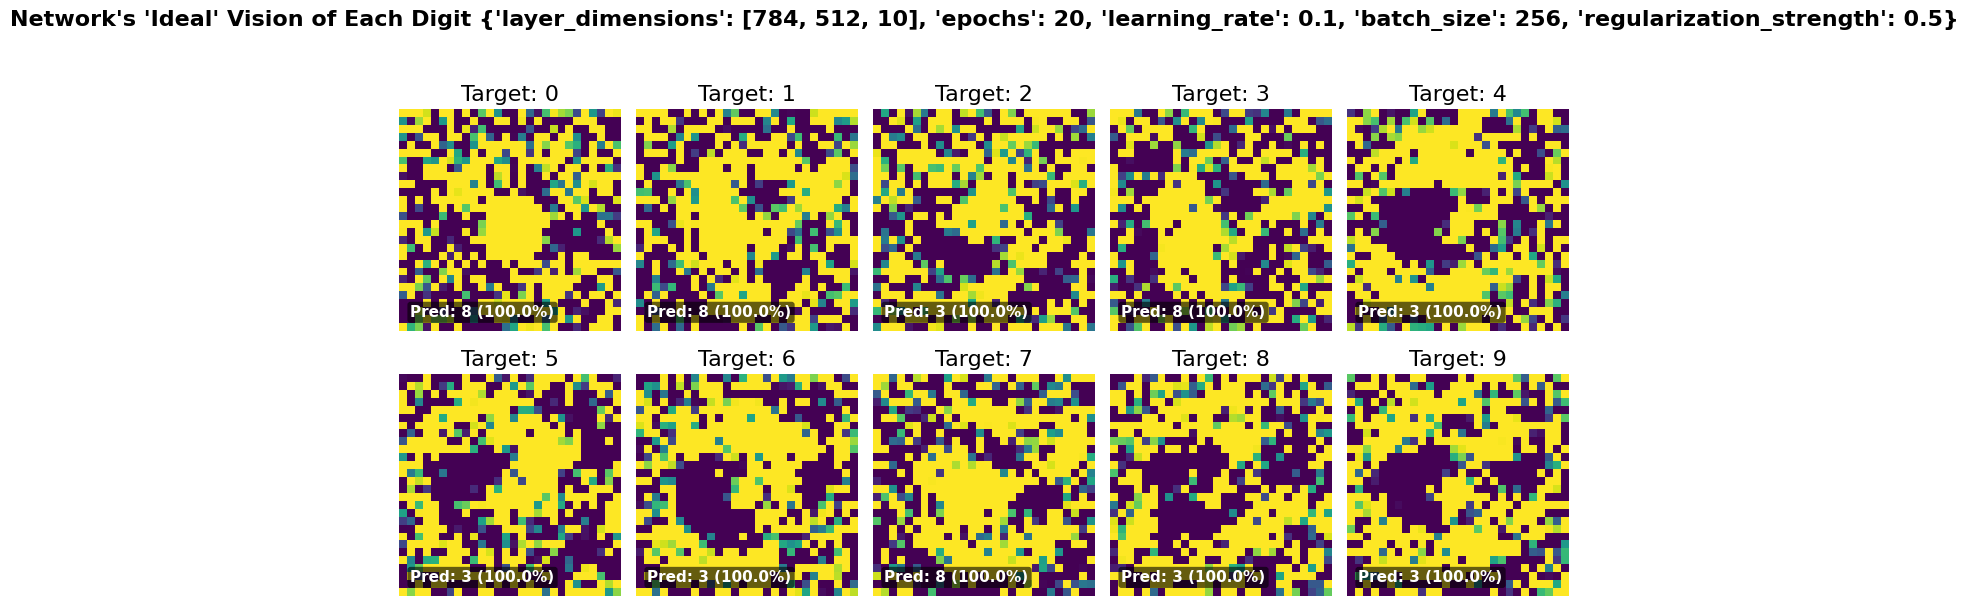

Generating images for configuration: {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0}


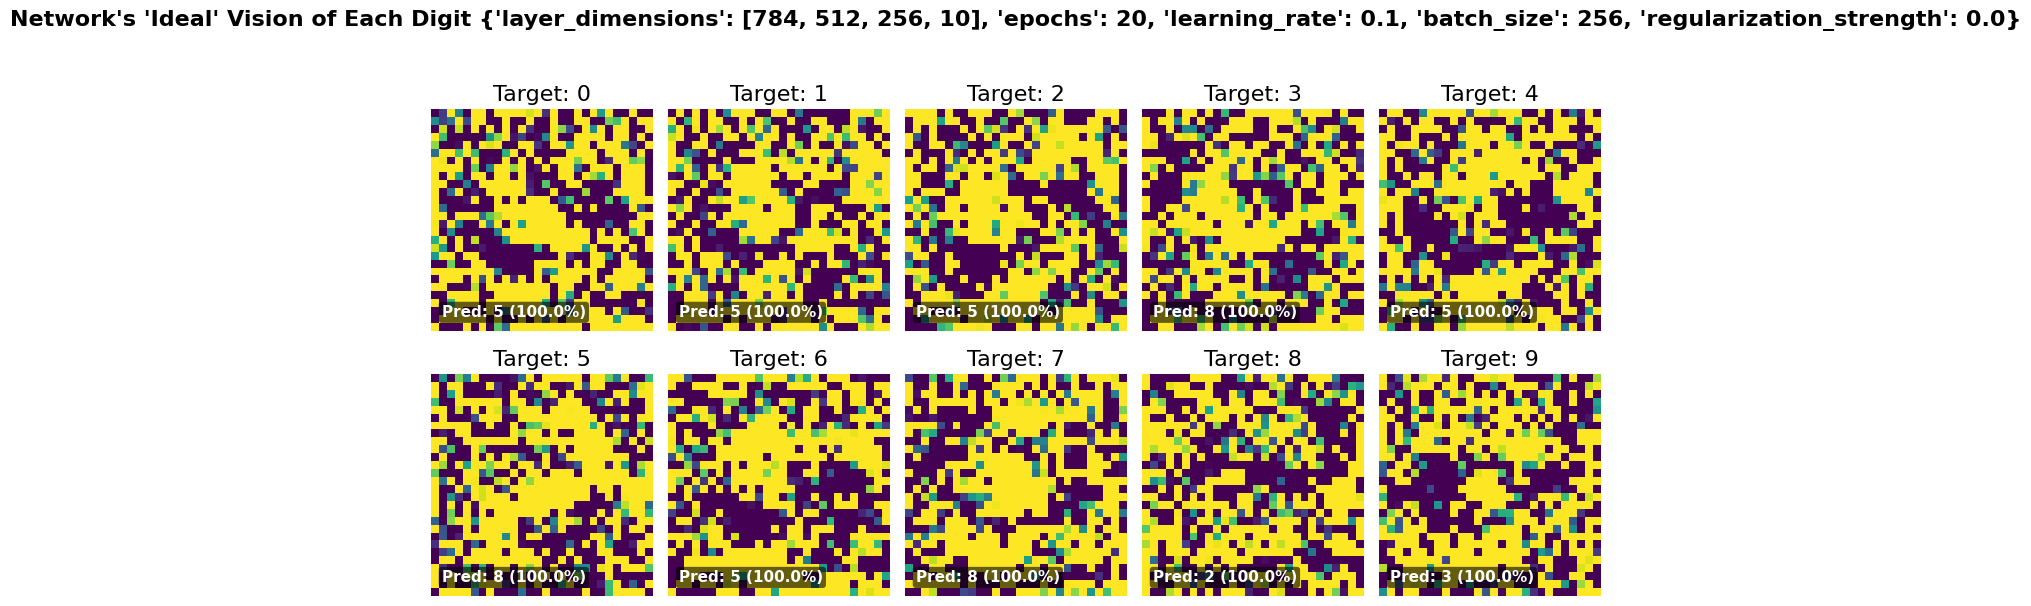

Generating images for configuration: {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01}


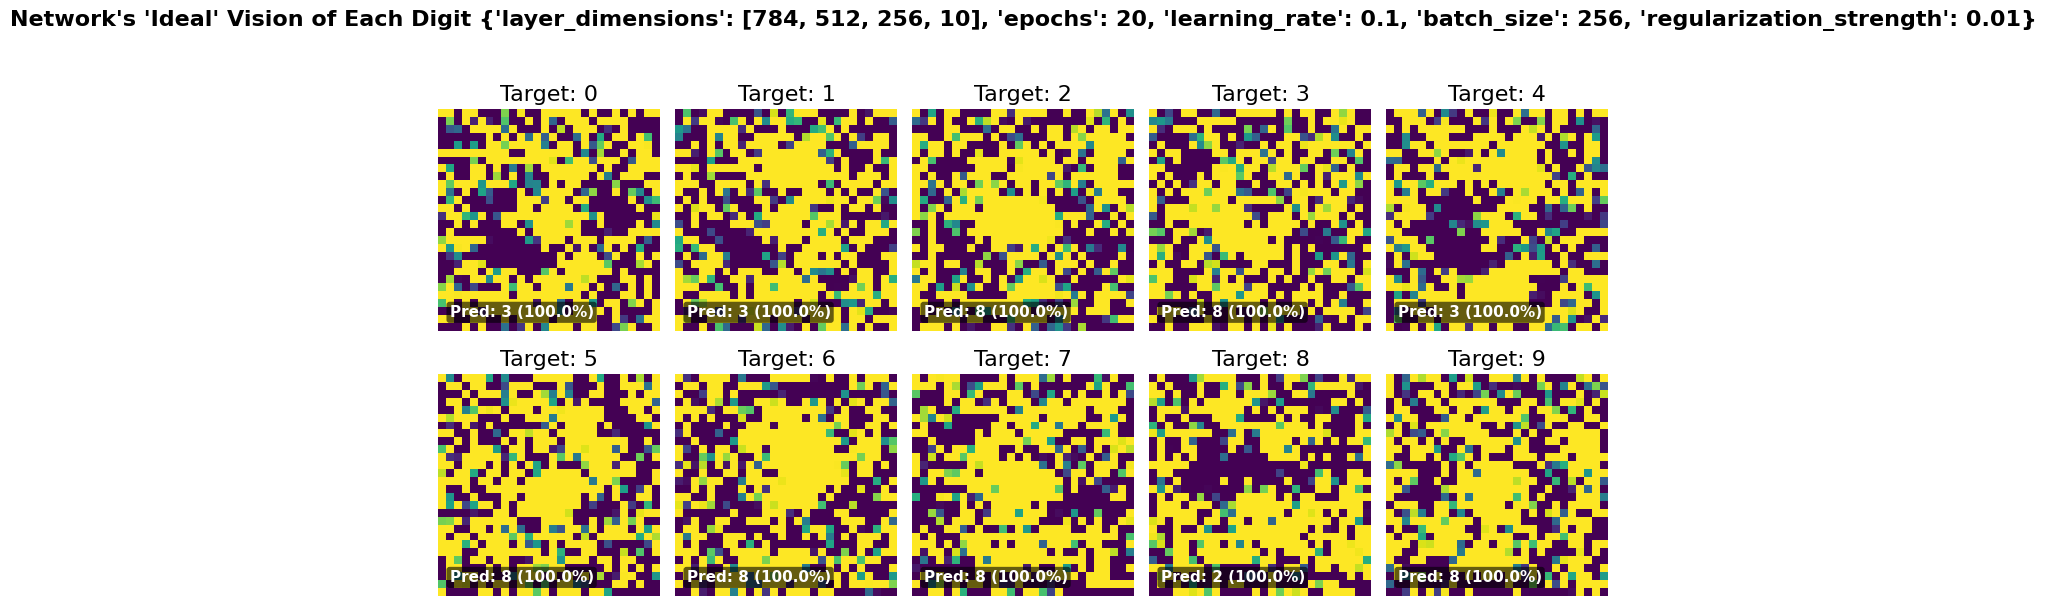

Generating images for configuration: {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1}


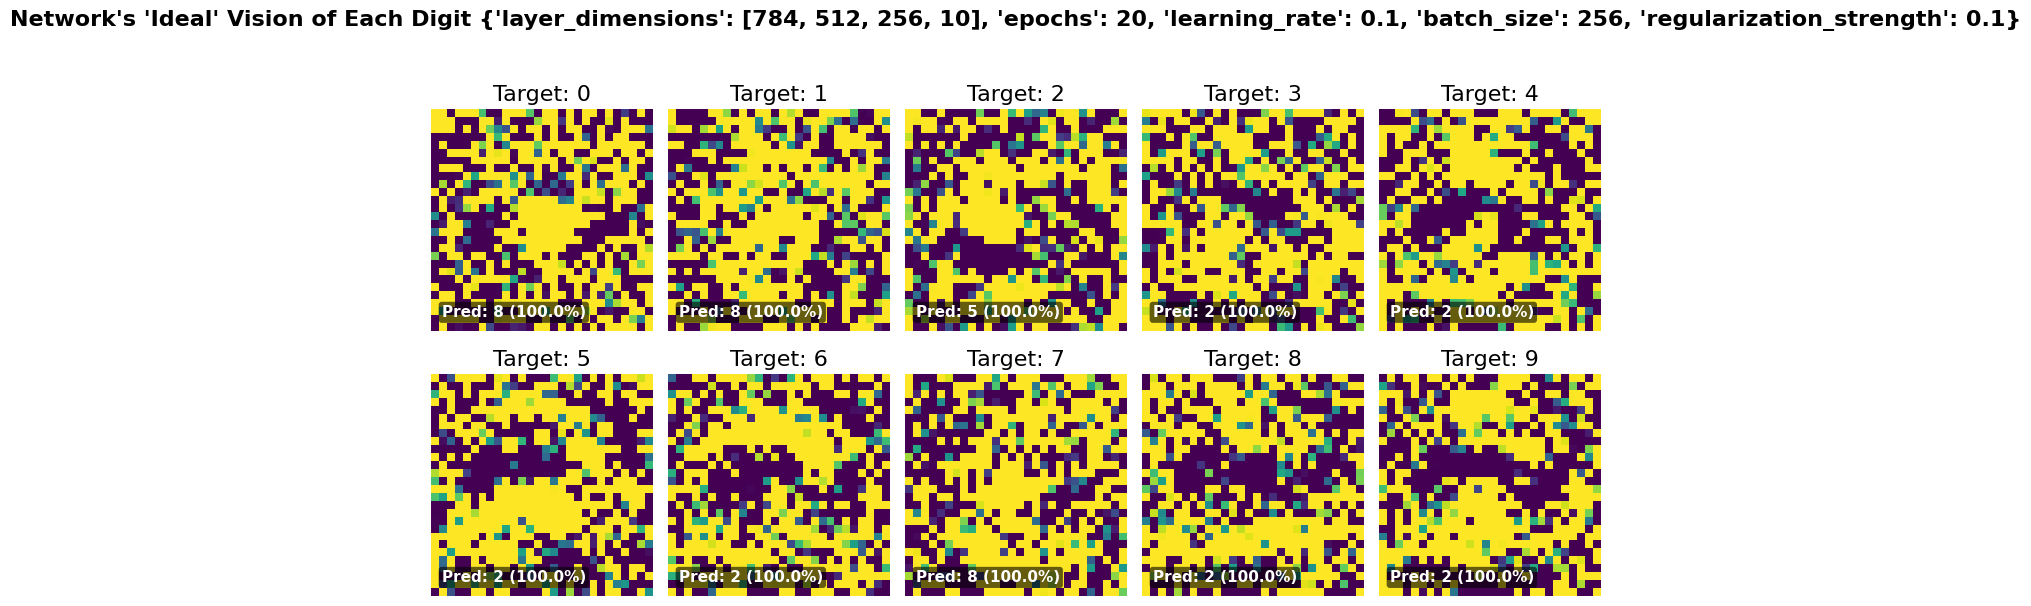

Generating images for configuration: {'layer_dimensions': [784, 512, 256, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5}


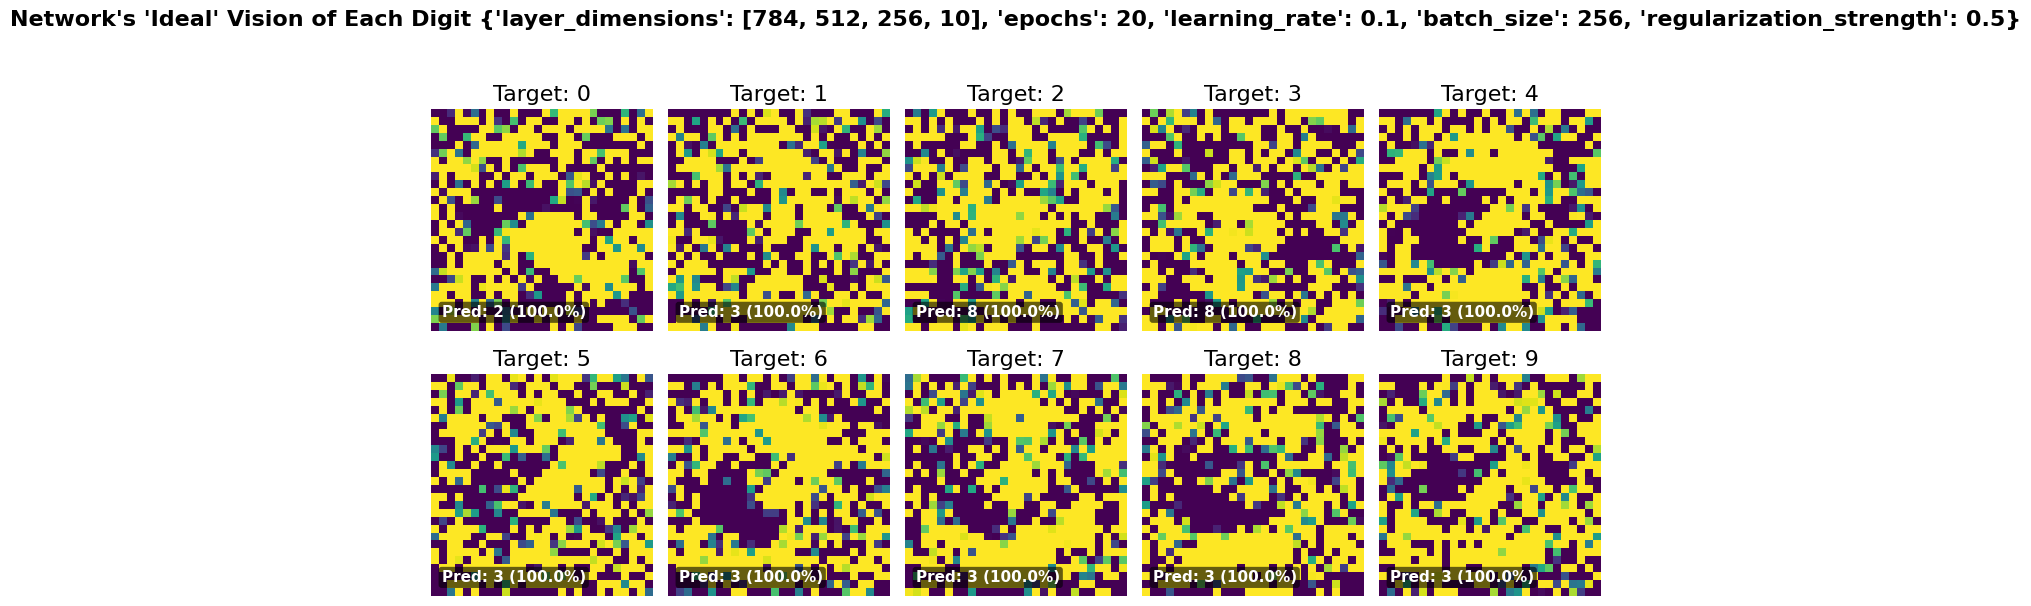

Generating images for configuration: {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.0}


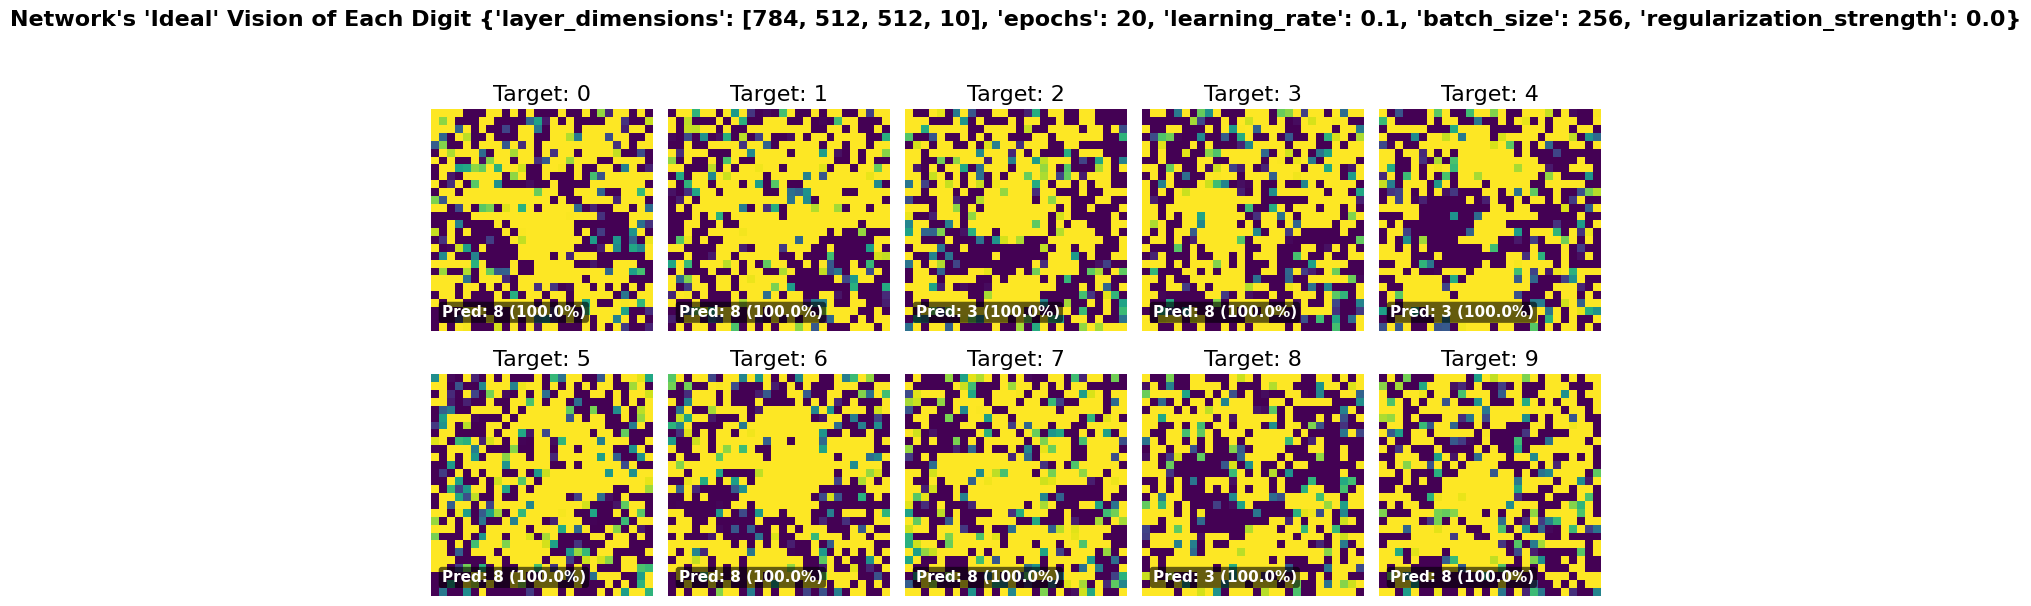

Generating images for configuration: {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.01}


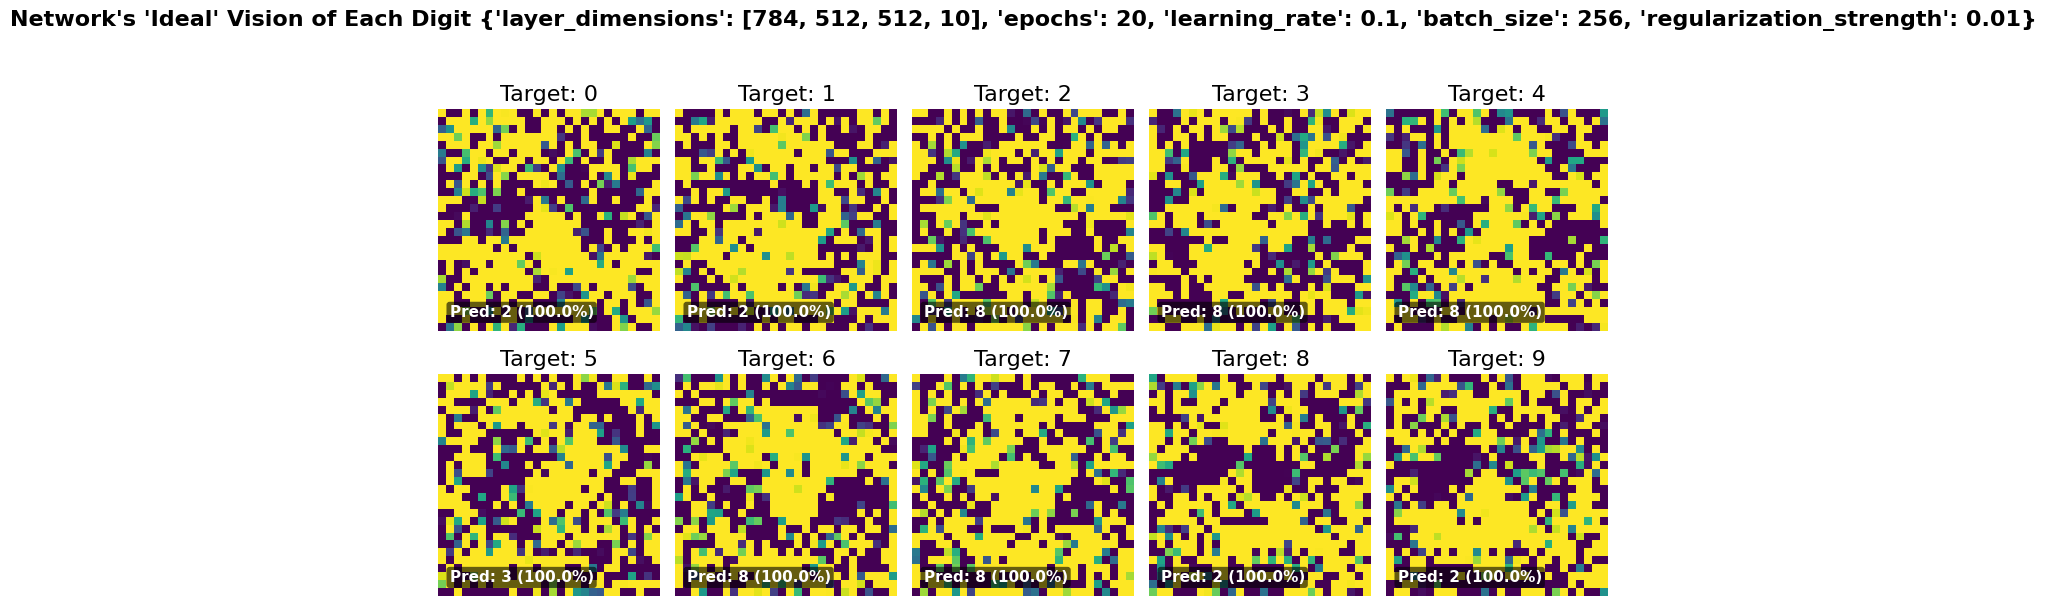

Generating images for configuration: {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.1}


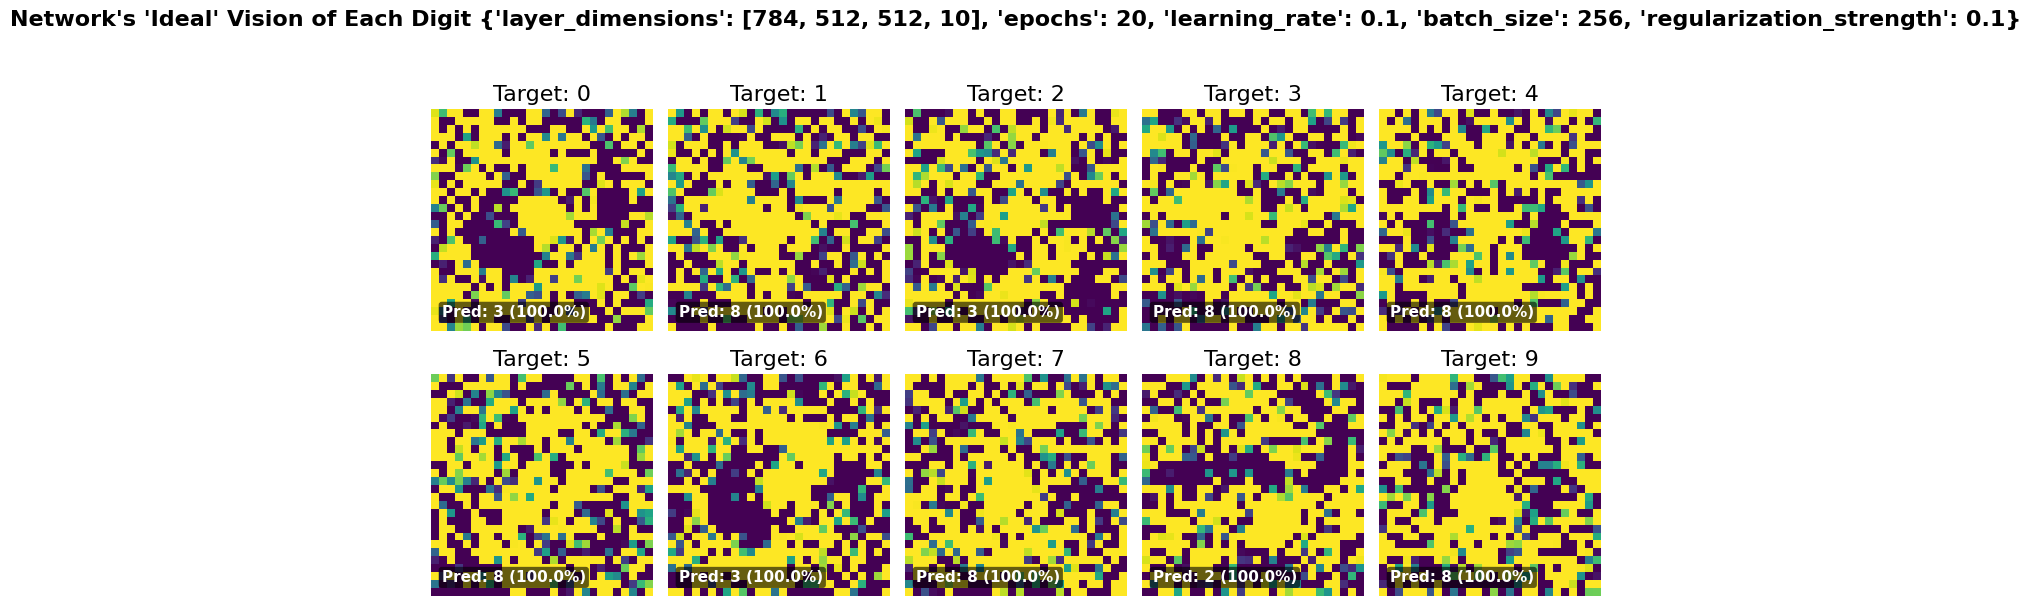

Generating images for configuration: {'layer_dimensions': [784, 512, 512, 10], 'epochs': 20, 'learning_rate': 0.1, 'batch_size': 256, 'regularization_strength': 0.5}


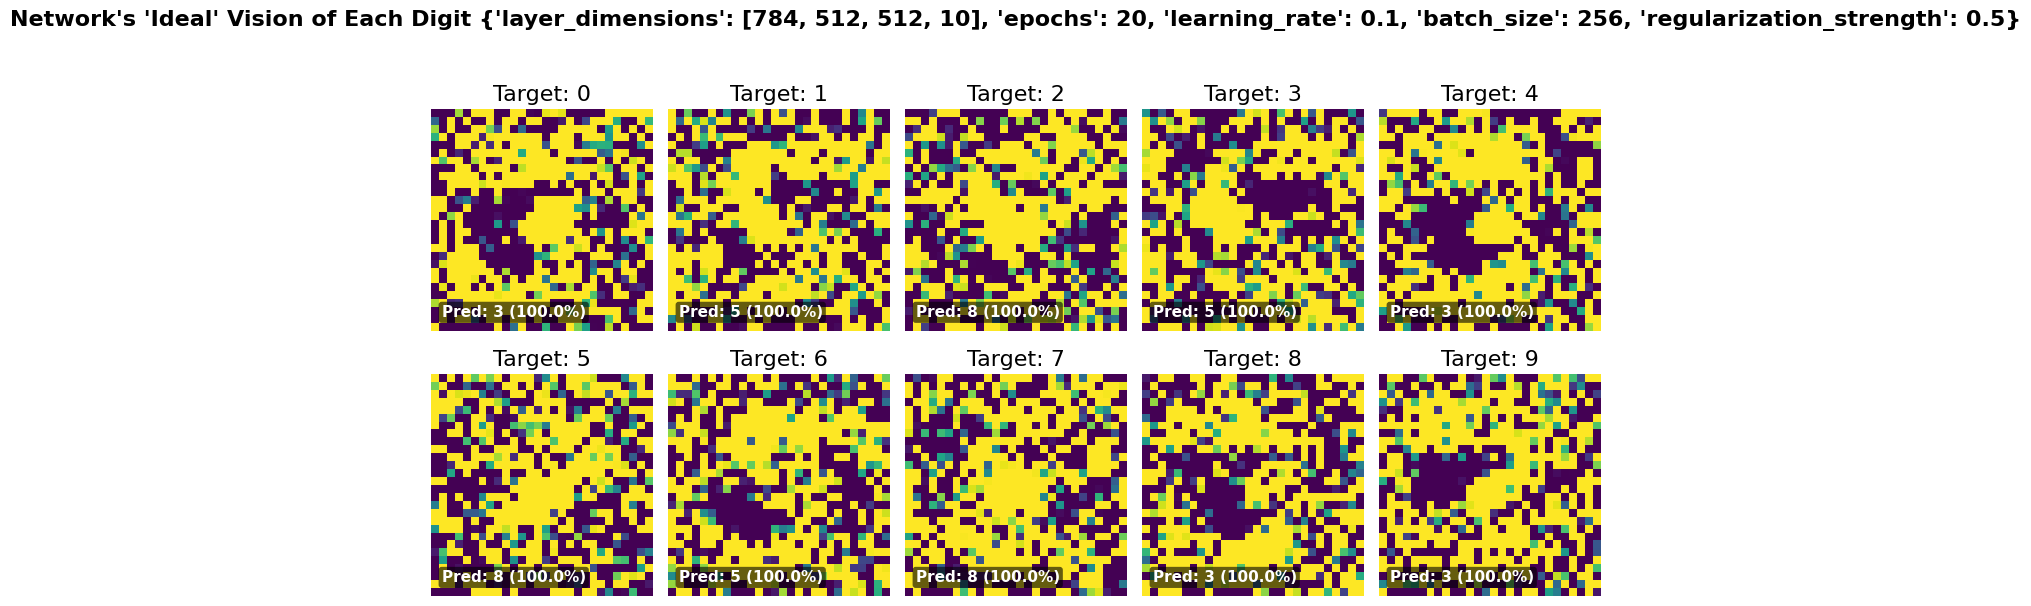

In [24]:
for (configuration, model, _, _) in configurable_mlp_results:
    generate_images(model, configuration)